**Student**: Irene Testa

**E-mail**: i.testa@studenti.unipi.it

**Roll number**: 582061

# Midterm 2 - Assignment 1

*Fitting Hidden Markov Models on air quality sensors.*

Installing the required library:

In [1]:
! pip install hmmlearn

Importing libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
from hmmlearn.hmm import GaussianHMM, GMMHMM
from scipy import stats
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
from IPython.display import Image
from sklearn.metrics import f1_score

# defining settings
pd.set_option('display.max_columns', None)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
%matplotlib inline

## Data Preparation and Exploration

In [3]:
# loading data
data_url = 'https://raw.githubusercontent.com/iretes/ISPR/main/midterm-2/data/AirQualityUCI.csv'
data = pd.read_csv(data_url, sep=';', decimal=',')
# drop rows containing all nan
data = data.dropna(how='all', axis=0)
# drop columns containing all nan
data = data.dropna(how='all', axis=1)
# parse and merge columns 'Date' and 'Time' into 'DateTime'
data['DateTime'] = pd.to_datetime(
    data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S')
# drop columns 'Date' and 'Time'
data = data.drop(columns=['Date', 'Time'])
# set 'DateTime' as index
data = data.set_index(['DateTime'])
# set elements '-200' to nan
data = data.replace(-200, np.nan)
data

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
DateTime                                                                      
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   
...                     ...          ...       ...       ...            ...   
2005-04-04 10:00:00     3.1       1314.0       NaN      13.5         1101.0   
2005-04-04 11:00:00     2.4       1163.0       NaN      11.4         1027.0   
2005-04-04 12:00:00     2.4       1142.0       NaN      12.4         1063.0   
2005-04-04 13:00:00     2.1       1003.0       NaN       9.5          961.0   
2005-04-04 14:00:00     2.2       1071.0       NaN      11.9         1047.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
DateTime                                                            
2004-03-10 18:00:00    166.0        1056.0    113.0        1692.0   
2004-03-10 19:00:00    103.0        1174.0     92.0        1559.0   
2004-03-10 20:00:00    131.0        1140.0    114.0        1555.0   
2004-03-10 21:00:00    172.0        1092.0    122.0        1584.0   
2004-03-10 22:00:00    131.0        1205.0    116.0        1490.0   
...                      ...           ...      ...           ...   
2005-04-04 10:00:00    472.0         539.0    190.0        1374.0   
2005-04-04 11:00:00    353.0         604.0    179.0        1264.0   
2005-04-04 12:00:00    293.0         603.0    175.0        1241.0   
2005-04-04 13:00:00    235.0         702.0    156.0        1041.0   
2005-04-04 14:00:00    265.0         654.0    168.0        1129.0   

                     PT08.S5(O3)     T    RH      AH  
DateTime                                              
2004-03-10 18:00:00       1268.0  13.6  48.9  0.7578  
2004-03-10 19:00:00        972.0  13.3  47.7  0.7255  
2004-03-10 20:00:00       1074.0  11.9  54.0  0.7502  
2004-03-10 21:00:00       1203.0  11.0  60.0  0.7867  
2004-03-10 22:00:00       1110.0  11.2  59.6  0.7888  
...                          ...   ...   ...     ...  
2005-04-04 10:00:00       1729.0  21.9  29.3  0.7568  
2005-04-04 11:00:00       1269.0  24.3  23.7  0.7119  
2005-04-04 12:00:00       1092.0  26.9  18.3  0.6406  
2005-04-04 13:00:00        770.0  28.3  13.5  0.5139  
2005-04-04 14:00:00        816.0  28.5  13.1  0.5028  

[9357 rows x 13 columns]

Computing the percentage of missing values in each column:

In [4]:
data.isna().mean() * 100

CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64

Defining a function for filling missing values using interpolation only when the consecutive NaNs fall below a specified threshold:

In [5]:
INTERPOLATION_LIMIT = 4
def interpolate(data, limit=INTERPOLATION_LIMIT):
    data = data.copy()
    for col in data.columns:
        mask = data[col].isna().groupby(data[col].notna().cumsum()).transform('count')<=limit+1
        data[col] = np.where(mask, data[col].interpolate(limit=limit), data[col])
    return data

Interpolating missing values using the function defined above or copying values from the previous or following day when there are more than 4 consecutive NaNs:

In [6]:
imputed_data = interpolate(data)
# copying from the previous day
prev_day = imputed_data.add(imputed_data.shift(24), fill_value=0)
imputed_data = imputed_data.combine_first(prev_day)
imputed_data = interpolate(imputed_data)
# copying from the succeeding day
succ_day = imputed_data.add(imputed_data.shift(-24), fill_value=0)
imputed_data = imputed_data.combine_first(succ_day)
imputed_data = interpolate(imputed_data)
# copying from the day before the previous day
prev_prev_day = imputed_data.add(imputed_data.shift(48), fill_value=0)
imputed_data = imputed_data.combine_first(prev_prev_day)
imputed_data = interpolate(imputed_data)
# copying from the day after the succeeding day
succ_succ_day = imputed_data.add(imputed_data.shift(-48), fill_value=0)
imputed_data = imputed_data.combine_first(succ_succ_day)
imputed_data = interpolate(imputed_data)
imputed_data.isna().mean() * 100

CO(GT)            0.545046
PT08.S1(CO)       0.000000
NMHC(GT)         86.074597
C6H6(GT)          0.000000
PT08.S2(NMHC)     0.000000
NOx(GT)           0.609170
PT08.S3(NOx)      0.000000
NO2(GT)           0.609170
PT08.S4(NO2)      0.000000
PT08.S5(O3)       0.000000
T                 0.000000
RH                0.000000
AH                0.000000
dtype: float64

Among the columns without missing values, I focused on 'PT08.S4(NO2)', measuring the hourly averaged $NO_2$ sensor response:

In [7]:
SENSOR = 'PT08.S4(NO2)'
imputed_data = imputed_data[[SENSOR]]
data = data[[SENSOR]]

Plotting the time series highlighting imputed values:

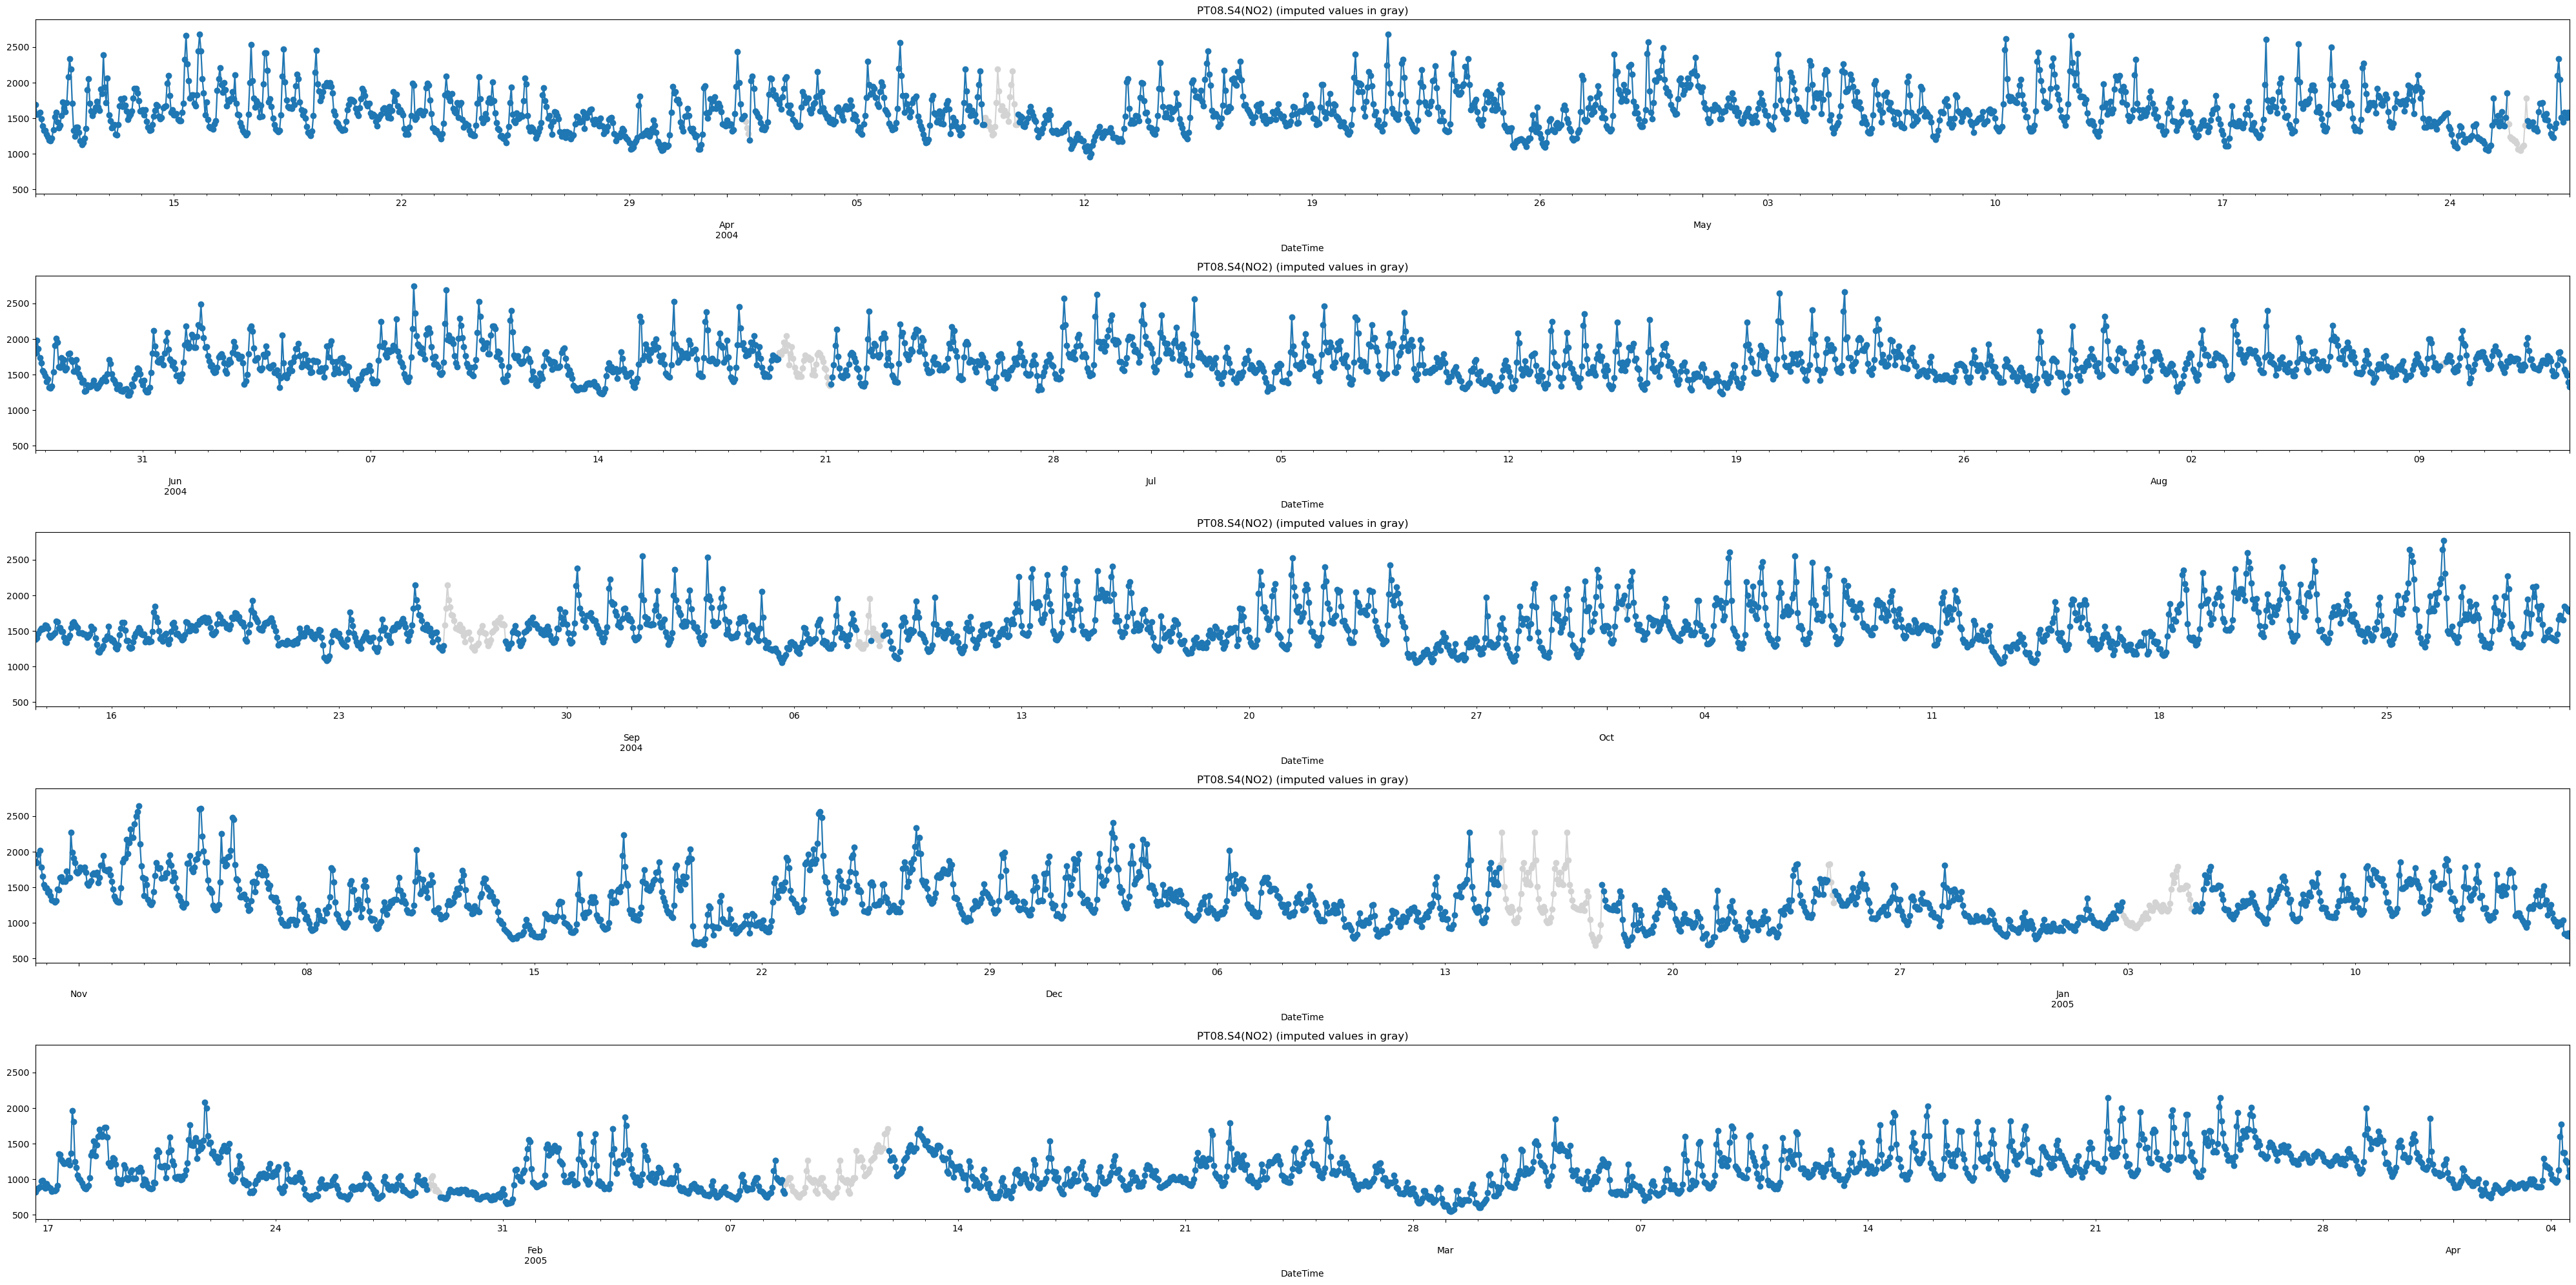

In [8]:
fig, axs = plt.subplots(5, figsize=(40, 20), sharey=True)
for i in range(5):
    imputed_data[int(data.shape[0]*i/5):int(data.shape[0]*(i+1)/5)].plot(kind='line', style='-o',  ax=axs[i], color='lightgray')
    data[int(data.shape[0]*i/5):int(data.shape[0]*(i+1)/5)].plot(kind='line', style='-o',  ax=axs[i])
    axs[i].set_title(f'{SENSOR} (imputed values in gray)')
    axs[i].get_legend().remove()
fig.tight_layout()

Visualizing the data:

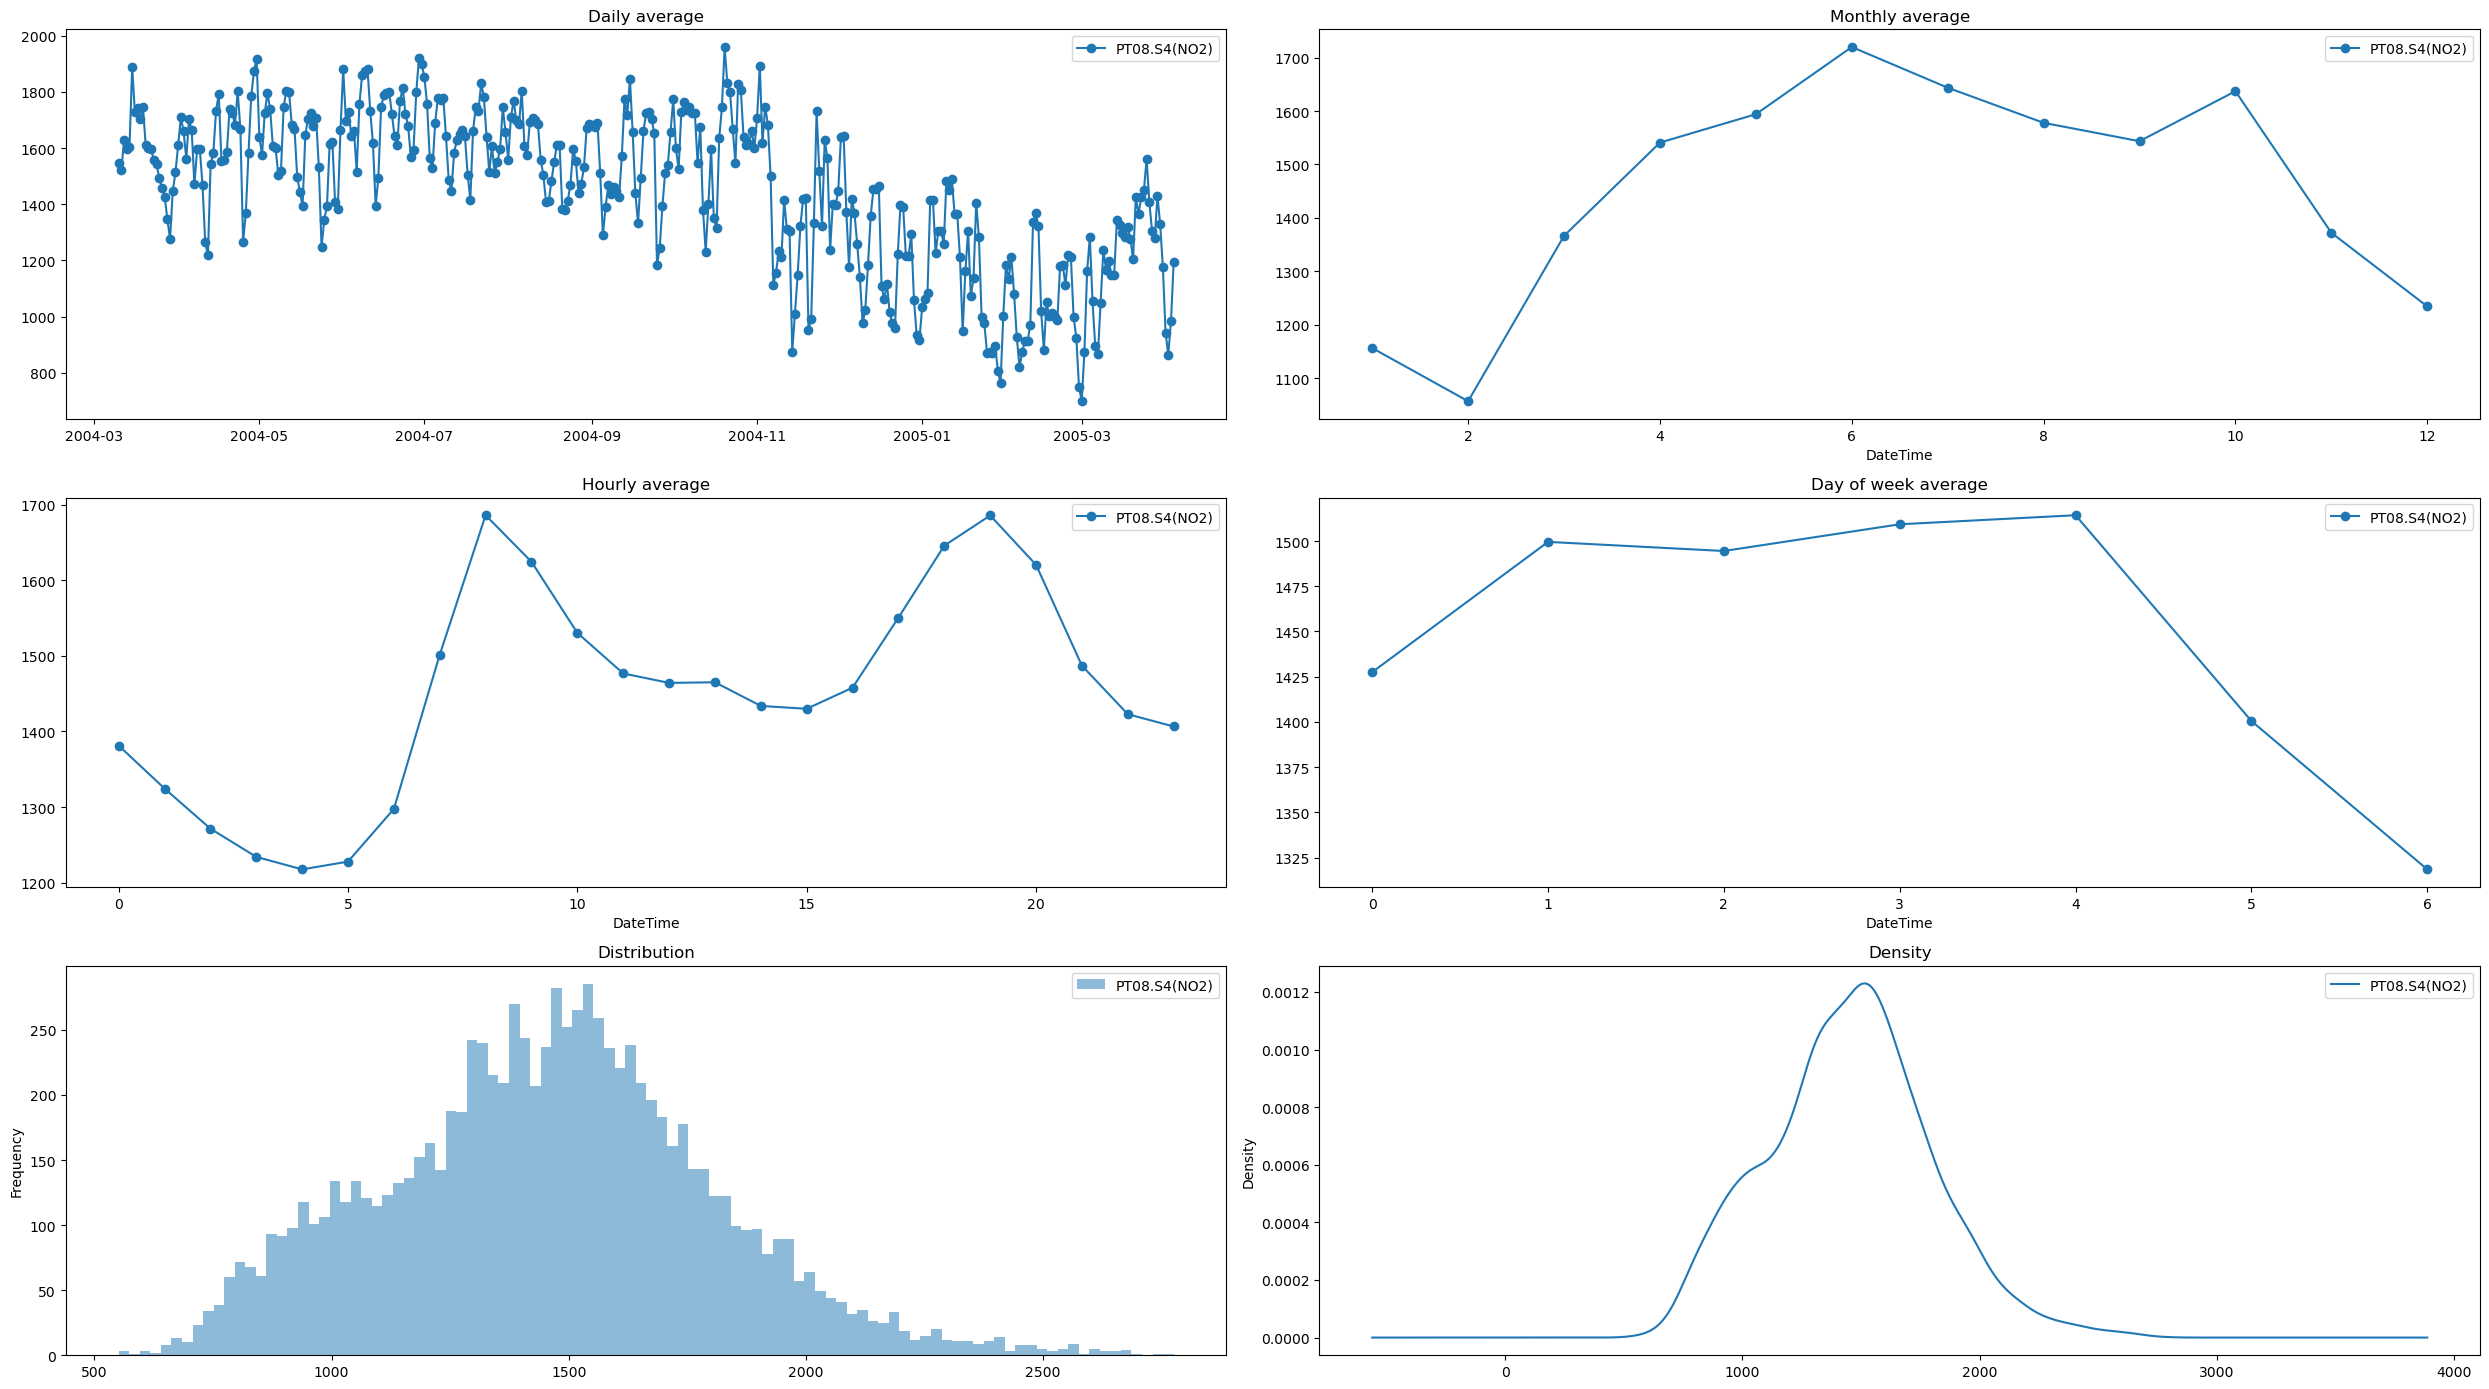

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(25, 14))
data = imputed_data.copy()
data.groupby(data.index.date).mean().plot(kind='line', style='-o',  ax=axs[0][0])
axs[0][0].set_title('Daily average')
data.groupby(data.index.month).mean().plot(kind='line', style='-o',  ax=axs[0][1])
axs[0][1].set_title('Monthly average')
data.groupby(data.index.hour).mean().plot(kind='line', style='-o',  ax=axs[1][0])
axs[1][0].set_title('Hourly average')
data.groupby(data.index.dayofweek).mean().plot(kind='line', style='-o',  ax=axs[1][1])
axs[1][1].set_title('Day of week average')
data.plot(kind='hist', bins=100, alpha=0.5, ax=axs[2][0])
axs[2][0].set_title('Distribution')
data.plot(kind='kde', ax=axs[2][1])
axs[2][1].set_title('Density');
fig.tight_layout()

$NO_2$ concentration peaks at 8 am and 7 pm and exhibits significantly lower values during weekends and in winter.

## Model Selection

I used the Hidden Markov Model implementation provided by the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library. I chose to experiment with Gaussian and Mixture of Gaussian distributions (with 2 and 3 components), the only two emission distributions for continuous data available in the library. Additionally, I experimented with HMMs with a varying number of hidden states: from 2 to 15 states with Gaussian Emissions, from 2 to 8 with Mixtures of 2 Gaussians and from 2 to 5 with Mixtures of 3 Gaussians. For mixtures of Gaussians, I opted to limit the number of states to keep the number of parameters low. Default parameters were used for 'covariance_type' ('diag'), indicating that each state's (and component's) emission distribution have different variances.

To select the best model, I split the sequence into training (the first 75%) and validation (the last 25%) sets and used the log-likelihood, Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) to compare the models. The latter two are penalized log-likelihoods that take into account the number of parameters of the model and could directly be used to compare models without the need of a validation set.

The parameters for prior, emission and transition distributions were randomly initialized and each model configuration was trained 3 times. All models were trained for a maximum of 1000 iterations, with a tolerance on the log-likelihood set at 0.1.

Performing grid search:

In [10]:
# split data into train and validation sets
train = data[:int(data.shape[0]*3/4)]
val = data[int(data.shape[0]*3/4):]

# setting maximum number of iterations and tolerance
MAX_ITER = 1000
TOL = 0.1

# defining grid of hyperparameters
grid = [
    {
        'model': ['gaussian'],
        'n_components': np.arange(2, 16),
        'n_iter': [MAX_ITER],
        'tol': [TOL],
        'random_state': np.arange(0, 3)
    },
    {
        'model': ['mixture of gaussians'],
        'n_components': np.arange(2, 9),
        'n_mix': [2],
        'n_iter': [MAX_ITER],
        'tol': [TOL],
        'random_state': np.arange(0, 3)
    },
    {
        'model': ['mixture of gaussians'],
        'n_components': np.arange(2, 6),
        'n_mix': [3],
        'n_iter': [MAX_ITER],
        'tol': [TOL],
        'random_state': np.arange(0, 3)
    }
]

# dictionary to store models and their performance
models = {
    'emission_dist': [], 'n_states': [], 'init': [], 'n_mix': [],
    'train_max_iter': [], 'train_converged': [],
    'train_log-likelihood': [], 'train_aic': [], 'train_bic': [],
    'val_log-likelihood': [], 'val_aic': [], 'val_bic': []
}

# performing grid search
for p in ParameterGrid(grid):
    print(f'Fitting model with parameters: {p}')
    if p['model'] == 'gaussian':
        h = GaussianHMM(**{k:v for k, v in p.items() if k != 'model'})
        models['n_mix'].append(1)
    else:
        h = GMMHMM(**{k:v for k, v in p.items() if k != 'model'})
        models['n_mix'].append(p['n_mix'])
    models['emission_dist'].append(p['model'])
    models['n_states'].append(p['n_components'])
    models['init'].append(p['random_state'])
    h.fit(train)
    models['train_max_iter'].append(h.monitor_.iter == h.monitor_.n_iter)
    models['train_converged'].append(h.monitor_.converged)
    models['train_log-likelihood'].append(h.score(train))
    models['train_aic'].append(h.aic(train))
    models['train_bic'].append(h.bic(train))
    models['val_log-likelihood'].append(h.score(val))
    models['val_aic'].append(h.aic(val))
    models['val_bic'].append(h.bic(val))

# converting dictionary to dataframe
models = pd.DataFrame(models)
models

Fitting model with parameters: {'model': 'gaussian', 'n_components': 2, 'n_iter': 1000, 'random_state': 0, 'tol': 0.1}
Fitting model with parameters: {'model': 'gaussian', 'n_components': 2, 'n_iter': 1000, 'random_state': 1, 'tol': 0.1}
Fitting model with parameters: {'model': 'gaussian', 'n_components': 2, 'n_iter': 1000, 'random_state': 2, 'tol': 0.1}
Fitting model with parameters: {'model': 'gaussian', 'n_components': 3, 'n_iter': 1000, 'random_state': 0, 'tol': 0.1}
Fitting model with parameters: {'model': 'gaussian', 'n_components': 3, 'n_iter': 1000, 'random_state': 1, 'tol': 0.1}
Fitting model with parameters: {'model': 'gaussian', 'n_components': 3, 'n_iter': 1000, 'random_state': 2, 'tol': 0.1}
Fitting model with parameters: {'model': 'gaussian', 'n_components': 4, 'n_iter': 1000, 'random_state': 0, 'tol': 0.1}
Fitting model with parameters: {'model': 'gaussian', 'n_components': 4, 'n_iter': 1000, 'random_state': 1, 'tol': 0.1}
Fitting model with parameters: {'model': 'gaussi

Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance


Fitting model with parameters: {'model': 'mixture of gaussians', 'n_components': 6, 'n_iter': 1000, 'n_mix': 2, 'random_state': 1, 'tol': 0.1}
Fitting model with parameters: {'model': 'mixture of gaussians', 'n_components': 6, 'n_iter': 1000, 'n_mix': 2, 'random_state': 2, 'tol': 0.1}
Fitting model with parameters: {'model': 'mixture of gaussians', 'n_components': 7, 'n_iter': 1000, 'n_mix': 2, 'random_state': 0, 'tol': 0.1}
Fitting model with parameters: {'model': 'mixture of gaussians', 'n_components': 7, 'n_iter': 1000, 'n_mix': 2, 'random_state': 1, 'tol': 0.1}
Fitting model with parameters: {'model': 'mixture of gaussians', 'n_components': 7, 'n_iter': 1000, 'n_mix': 2, 'random_state': 2, 'tol': 0.1}
Fitting model with parameters: {'model': 'mixture of gaussians', 'n_components': 8, 'n_iter': 1000, 'n_mix': 2, 'random_state': 0, 'tol': 0.1}
Fitting model with parameters: {'model': 'mixture of gaussians', 'n_components': 8, 'n_iter': 1000, 'n_mix': 2, 'random_state': 1, 'tol': 0.1}

emission_dist  n_states  init  n_mix  train_max_iter  \
0               gaussian         2     0      1           False   
1               gaussian         2     1      1           False   
2               gaussian         2     2      1           False   
3               gaussian         3     0      1           False   
4               gaussian         3     1      1           False   
..                   ...       ...   ...    ...             ...   
70  mixture of gaussians         4     1      3           False   
71  mixture of gaussians         4     2      3           False   
72  mixture of gaussians         5     0      3           False   
73  mixture of gaussians         5     1      3           False   
74  mixture of gaussians         5     2      3           False   

    train_converged  train_log-likelihood      train_aic      train_bic  \
0              True         -48301.625609   96617.251219   96665.243856   
1              True         -48302.736106   96619.472211   96667.464849   
2              True         -50079.325148  100172.650295  100220.642932   
3              True         -50079.492726  100186.985452  100282.970726   
4              True         -48298.543952   96625.087904   96721.073179   
..              ...                   ...            ...            ...   
70             True         -45424.539209   90931.078418   91212.178151   
71             True         -45438.835617   90959.671233   91240.770966   
72             True         -45006.755824   90125.511649   90509.452748   
73             True         -44964.851582   90041.703163   90425.644262   
74             True         -44992.710256   90097.420512   90481.361611   

    val_log-likelihood       val_aic       val_bic  
0        -17851.322613  35716.645226  35756.950570  
1        -17847.706556  35709.413112  35749.718456  
2        -18630.395831  37274.791662  37315.097005  
3        -18631.289515  37290.579030  37371.189717  
4        -17851.935188  35731.870376  35812.481063  
..                 ...           ...           ...  
70       -15905.534853  31893.069706  32129.143861  
71       -15878.036645  31838.073290  32074.147445  
72       -15849.298538  31810.597076  32133.039823  
73       -15811.158044  31734.316088  32056.758836  
74       -15860.625086  31833.250172  32155.692920  

[75 rows x 12 columns]

Computing mean, max and standard deviation of each score across all model configurations:

In [11]:
models_grouped = models.groupby(['emission_dist', 'n_states', 'n_mix']).agg({
    'train_log-likelihood': ['mean', 'std', 'max'],
    'train_aic': ['mean', 'std', 'min'],
    'train_bic': ['mean', 'std', 'min'],
    'train_converged': ['mean'],
    'train_max_iter': ['mean'],
    'val_log-likelihood': ['mean', 'std', 'max'],
    'val_aic': ['mean', 'std', 'min'],
    'val_bic': ['mean', 'std', 'min']
})
models_grouped.style.background_gradient(cmap='Blues', axis=0)

Visualizing the grid search results:

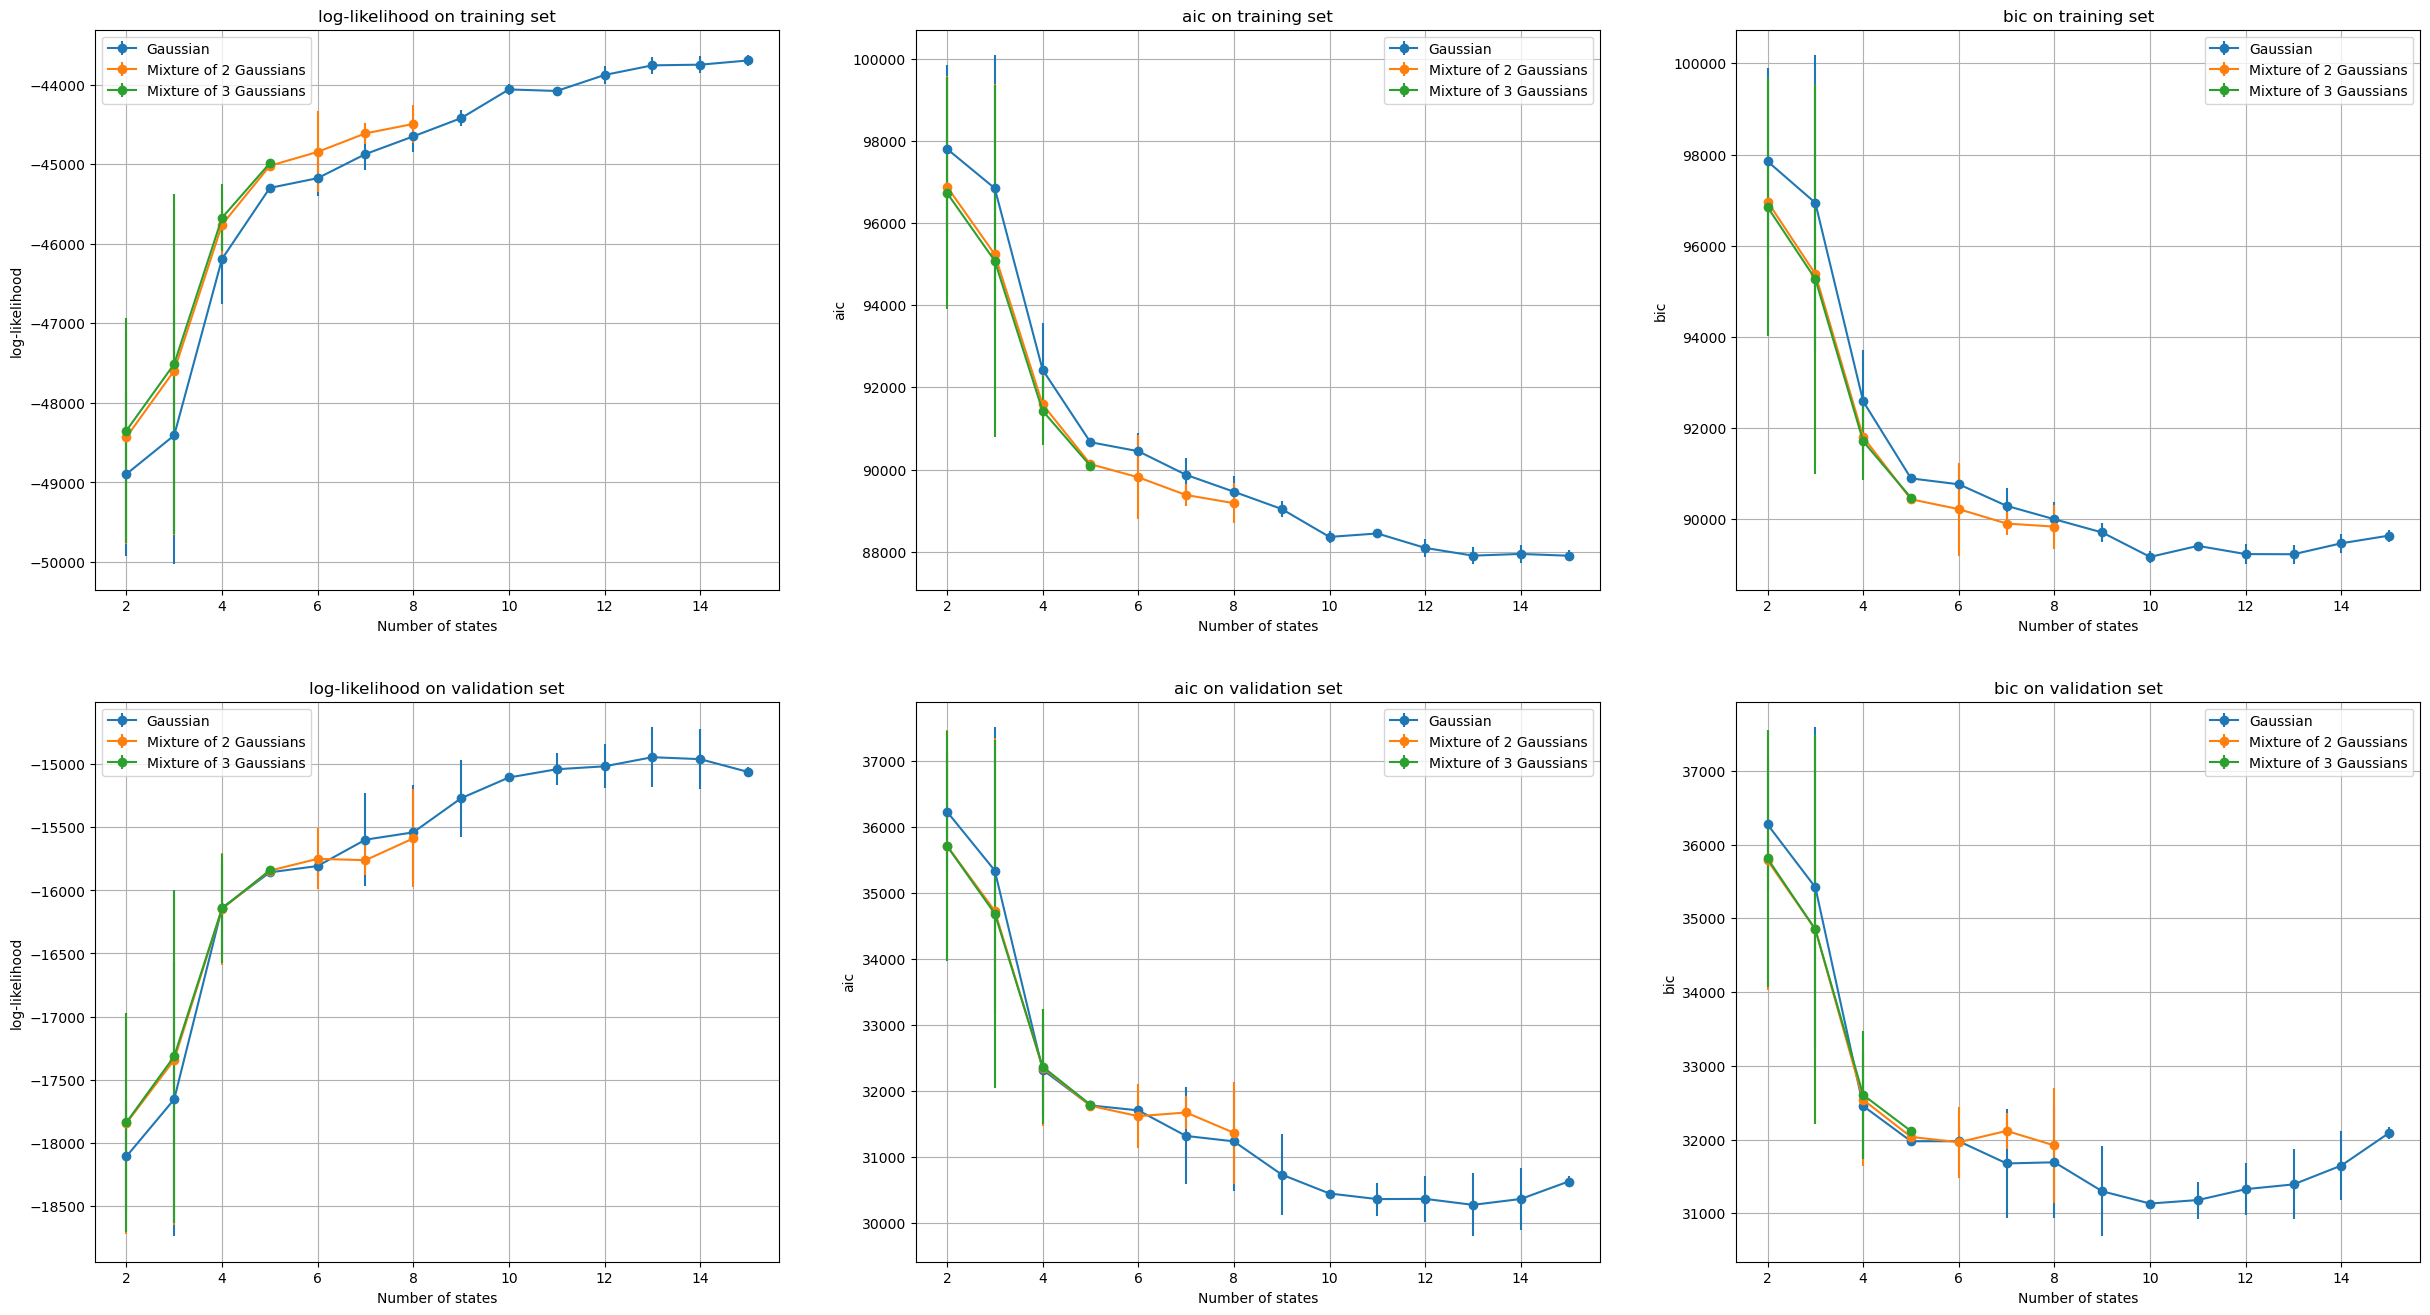

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(30, 16))

gaussian_models = models_grouped.loc['gaussian']
mixture2_models = models_grouped.loc['mixture of gaussians', :, 2]
mixture3_models = models_grouped.loc['mixture of gaussians', :, 3]

for i, set in enumerate(['train', 'val']):
    for j, score in enumerate(['log-likelihood', 'aic', 'bic']):
        for k, (model, model_name) in enumerate(zip(
            [gaussian_models, mixture2_models, mixture3_models],
            ['Gaussian', 'Mixture of 2 Gaussians', 'Mixture of 3 Gaussians'])):
            axs[i][j].errorbar(
                model.index.get_level_values('n_states'),
                model[f'{set}_{score}']['mean'],
                yerr=model[f'{set}_{score}']['std'],
                marker='o', label=f'{model_name}',
                color=sns.color_palette('tab20')[k*2])
            axs[i][j].set_xlabel('Number of states')
            axs[i][j].set_ylabel(score)
            axs[i][j].set_title(f'{score} on ' 
                f"{'training' if set =='train' else 'validation'} set")
            axs[i][j].legend()
            axs[i][j].grid()

Observations:
- The previous table shows that for all the models the training stopped before reaching the maximum number of iterations.
- With few states the standard deviation of the scores is high, suggesting that the initialization of the parameters has a significant impact on the model's performance.
- The difference between the scores on the training and validation sets also depends on the length of the sequence, as the validation set is a third of the training set.
- With Gaussian emissions, the log-likelihood demonstrates signs of overfitting after 13 states. Both the AIC and BIC curves show an elbow at 5 and 10 states. 

I further investigated models with 5 states, as both Gaussian and Mixture of 2 Gaussians models display a distinct elbow in their BIC and AIC scores at this threshold, affirming its significance. Models with 10 states were not considered, as they would be harder to interpret.

Training again models 5 times and selecting the best model according to the log-likelihood to avoid local minima:

In [13]:
best_models_params = {
    'Gaussian': {'n_components': 5, 'n_iter': MAX_ITER, 'tol': TOL},
    'Mixture of 2 Gaussians': {'n_components': 5, 'n_iter': MAX_ITER, 'tol': TOL, 'n_mix': 2},
    'Mixture of 3 Gaussians': {'n_components': 5, 'n_iter': MAX_ITER, 'tol': TOL, 'n_mix': 3}
}
best_ll = {name: None for name in best_models_params.keys()}
best_models = {name: None for name in best_models_params.keys()}
for name, params in best_models_params.items():
    print(f"Fitting {name}...")
    for i in range(5):
        params.update({'random_state': i})
        print(f"Fitting {params}")
        if name == 'Gaussian':
            h = GaussianHMM(**params)
        else:
            h = GMMHMM(**params)
        h.fit(train)
        score = h.score(train)
        if not best_ll[name] or best_ll[name] < score:
            best_ll[name] = score
            best_models[name] = h

Fitting Gaussian...
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'random_state': 0}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'random_state': 1}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'random_state': 2}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'random_state': 3}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'random_state': 4}
Fitting Mixture of 2 Gaussians...
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 2, 'random_state': 0}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 2, 'random_state': 1}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 2, 'random_state': 2}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 2, 'random_state': 3}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 2, 'random_state': 4}
Fitting Mixture of 3 Gaussians...
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 0}
Fitting {'n_com

### Model convergence

Plotting the log-likelihood of the models during training:

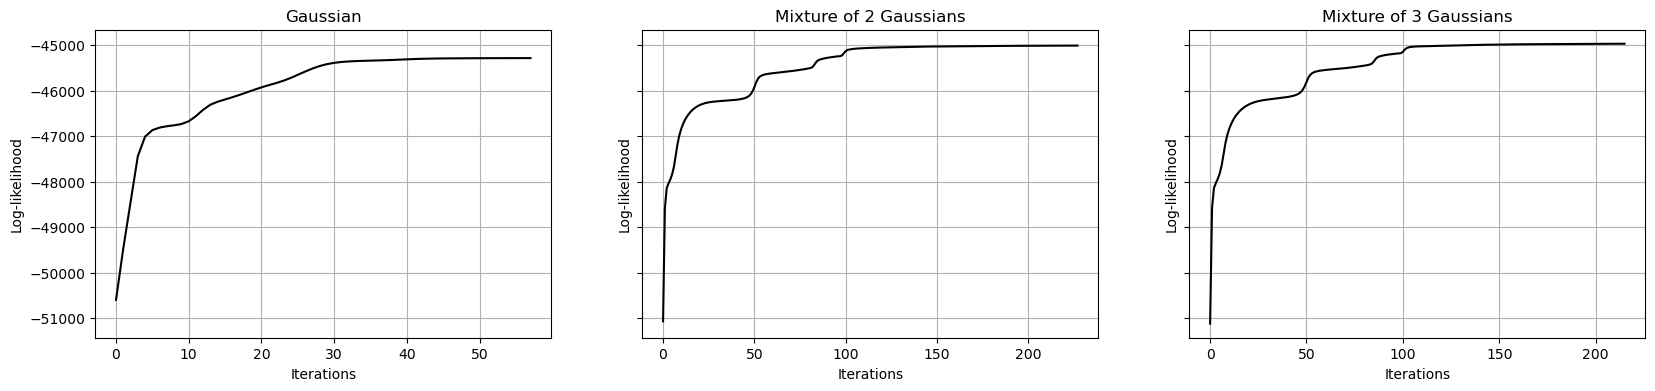

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
for i, model in enumerate(best_models_params.keys()):
    axs[i].plot(best_models[model].monitor_.history, color='black')
    axs[i].set_title(model)
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Log-likelihood')
    axs[i].grid()

Observations:
- All the models converged before reaching the maximum number of iterations.
- Models with Mixture of Gaussians as emission distribution requires more iterations to converge.

### Inspection of learned parameters

Plotting prior, emission and transition distributions of the models:

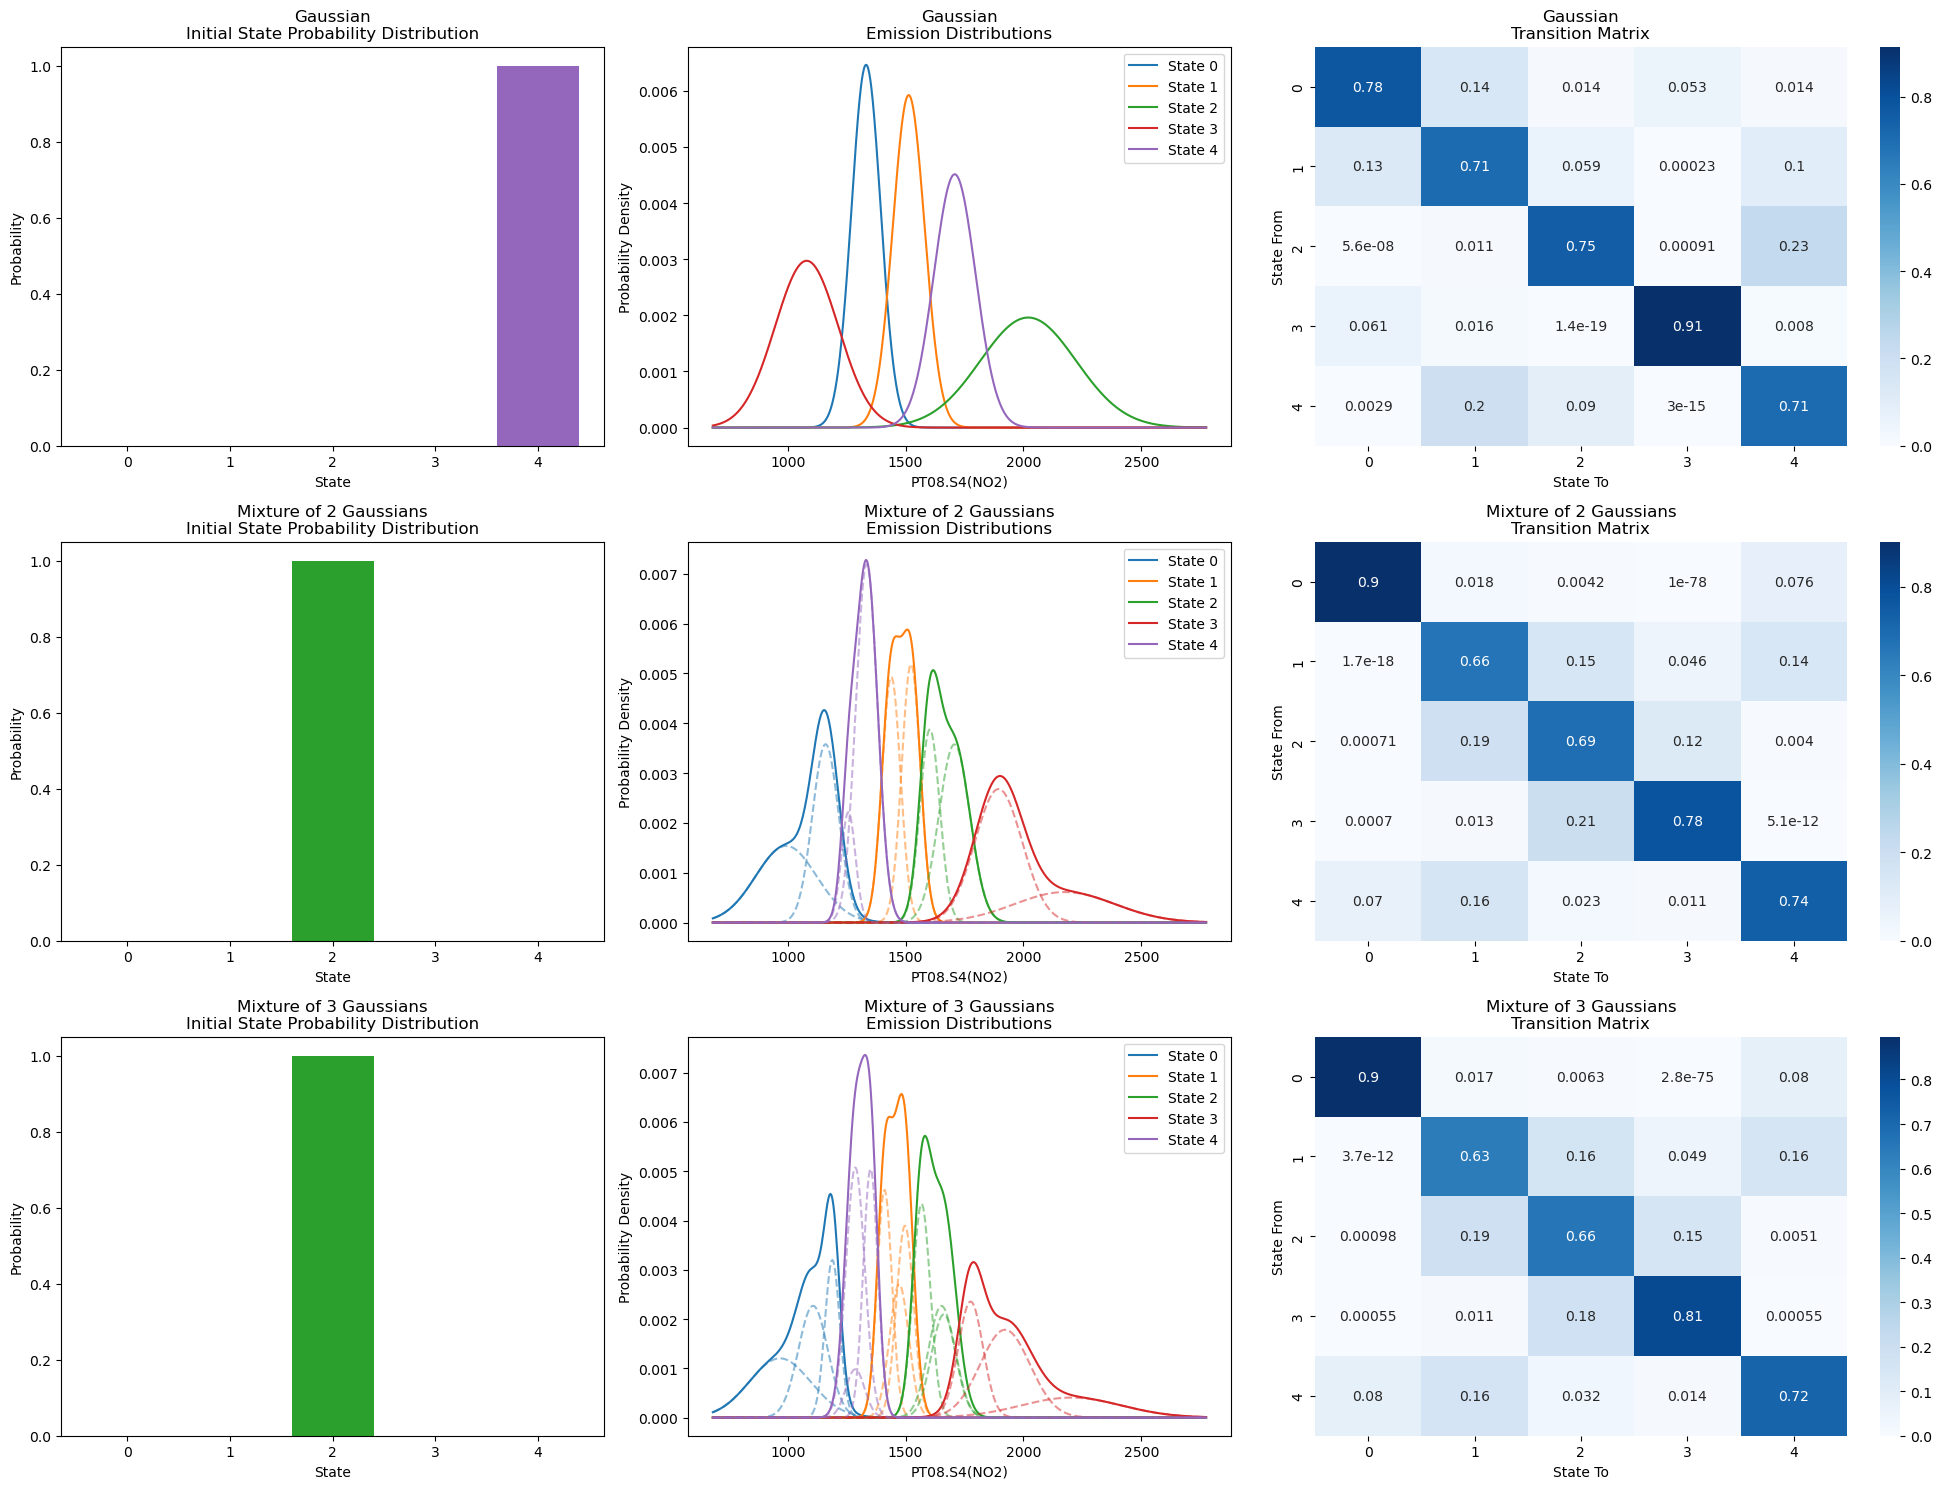

In [15]:
fig, axs = plt.subplots(
    3, 3, figsize=(20, 15), gridspec_kw={'width_ratios': [0.31, 0.31, 0.38]})

for i, (model, params) in enumerate(best_models_params.items()):
    # prior
    axs[i][0].bar(
        np.arange(0, best_models[model].n_components),
        height=best_models[model].startprob_,
        color=sns.color_palette('tab10')[:best_models[model].n_components])
    axs[i][0].set_xlabel('State')
    axs[i][0].set_ylabel('Probability')
    axs[i][0].set_title(f'{model}\nInitial State Probability Distribution')

    # emission
    if model == 'Gaussian':
        means = best_models[model].means_.reshape(-1)
        covars = best_models[model].covars_.reshape(-1)
        for j, (m, c) in enumerate(zip(means, covars)):
            g = stats.norm(m, np.sqrt(c))
            xs = np.linspace(np.min(train), np.max(train), 1000)
            axs[i][1].plot(xs, g.pdf(xs), label=f'State {j}')
    else:
        mix_means = best_models[model].means_
        mix_covars = best_models[model].covars_
        mix_weights = best_models[model].weights_
        for j, (m, c, w) in enumerate(zip(mix_means, mix_covars, mix_weights)):
            # plot the mixture
            g0 = stats.norm(m[0], np.sqrt(c[0]))
            xs = np.linspace(np.min(train[SENSOR]), np.max(train[SENSOR]), 500)
            ys = g0.pdf(xs)*w[0]
            for mix in range(1, params['n_mix']):
                g = stats.norm(m[mix], np.sqrt(c[mix]))
                ys += g.pdf(xs)*w[mix]
            axs[i][1].plot(
                xs, ys,
                label=f'State {j}', color=sns.color_palette('tab10')[j])
            # plot the components
            for mix in range(params['n_mix']):
                g = stats.norm(m[mix], np.sqrt(c[mix]))
                axs[i][1].plot(
                    xs, g.pdf(xs)*w[mix], '--',
                    color=sns.color_palette('tab10')[j], alpha=0.5)
    axs[i][1].set_ylabel('Probability Density')
    axs[i][1].set_xlabel(SENSOR)
    axs[i][1].set_title(f'{model}\nEmission Distributions');
    axs[i][1].legend();

    # transition
    sns.heatmap(
        best_models[model].transmat_, cmap="Blues", annot=True, ax=axs[i][2])
    axs[i][2].set_title(f'{model}\nTransition Matrix')
    axs[i][2].set_xlabel('State To')
    axs[i][2].set_ylabel('State From')
fig.tight_layout()

Observations:
- In all the cases the states delineate 5 distinct data regimes: low, medium-low, medium, medium-high, and high levels of $NO_2$.
- The prior distributions are uniformly concentrated on a singular state, aligning with the medium-high regime, across all models.
- The emission distributions in all models exhibit no overlap.
- The emission distributions of the Mixture of Gaussians models are quite similar, differing only in the distribution of the state corresponding to low and high regime.
- The transition matrices demonstrate substantial similarity across all models, underscoring consistency in state transitions.

### Comparison between the distribution of data sampled from the model and the original data

To select the best emission distribution I sampled data from each model and compare it with the training data. The initial state is randomly sampled according to the prior distribution:

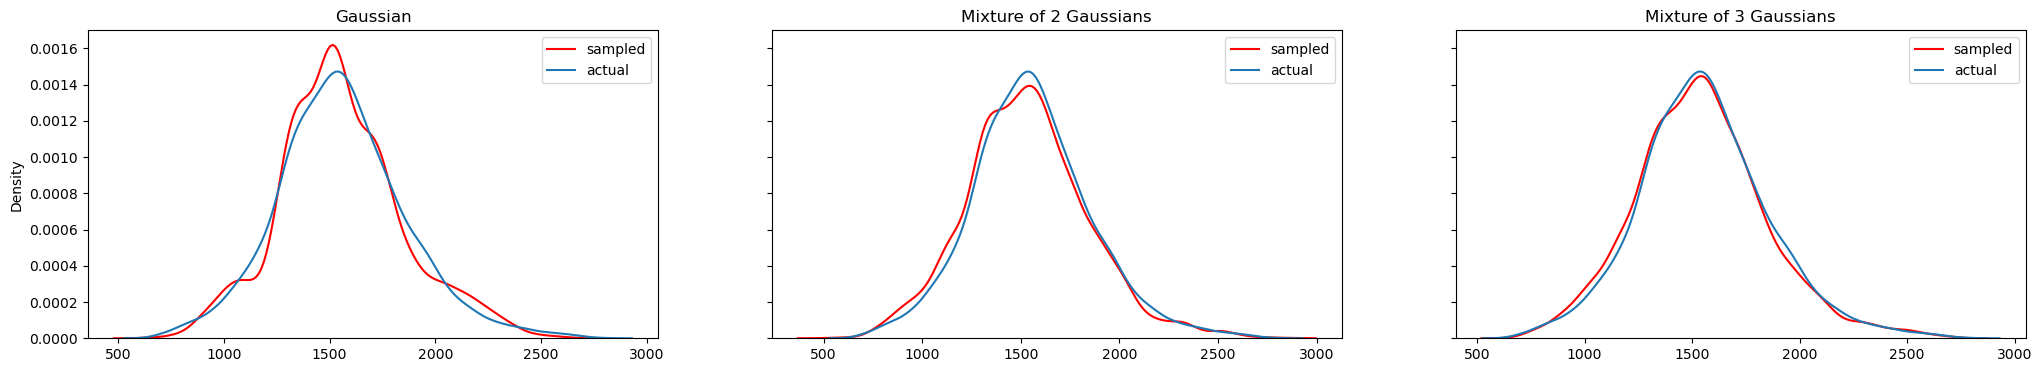

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(25, 4), sharey=True)
for i, model in enumerate(best_models_params.keys()):
    # sample from the model
    e, s = best_models[model].sample(
        train.shape[0],
        random_state=RANDOM_STATE)
    # plot the sampled data distribution
    sns.kdeplot(e.reshape(-1), label='sampled', ax=axs[i], color='red')
    # plot the actual data distribution
    sns.kdeplot(train, label='actual', ax=axs[i])
    axs[i].set_title(model)
    axs[i].legend()

It is evident that the data sampled from the Mixtures of 3 Gaussians model fits the original data better than the other models. I opted to focus on this model, training it 10 times on the entire time series and choosing the best-performing model based on the log-likelihood:

In [17]:
best_ll = None
best_model = None
for i in range(10):
    params = best_models_params['Mixture of 3 Gaussians'].copy()
    params.update({'random_state': i})
    print(f"Fitting {params}")
    h = GMMHMM(**params)
    h.fit(data)
    score = h.score(data)
    if not best_ll or best_ll < score:
        best_ll = score
        best_model = h
best_model

Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 0}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 1}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 2}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 3}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 4}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 5}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 6}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 7}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 8}
Fitting {'n_components': 5, 'n_iter': 1000, 'tol': 0.1, 'n_mix': 3, 'random_state': 9}


GMMHMM(covars_prior=array([[[-1.5],
        [-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5],
        [-1.5]],

       [[-1.5],
        [-1.5],
        [-1.5]]]),
       covars_weight=array([[[0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.]]]),
       means_prior=array([[[0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.]]]),
       means_weight=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]),
       n_components=5, n_iter=1000, n_mix=3, random_state=7, tol=0.1,
       weights_prior=array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]]))

## State assignment

 The decoding problem can be solved using the **Viterbi algorithm**, which finds the most likely *sequence* of states given the observations, or using **posterior decoding**, which provides the most likely *state* at any time point. Posterior decoding may give an invalid sequence of states (with 0 probability) because it does not consider how likely the transitions between states are.

Running Viterbi and posterior decoding (Maximum a Posteriori [MAP]) on the last 25% of the timeseries:

In [18]:
final_seq = data[int(data.shape[0]*3/4):].copy()
viterbi_final_states = best_model.decode(final_seq, algorithm='viterbi')[1]
map_final_states = best_model.decode(final_seq, algorithm='map')[1]

Plotting the timeseries highlighting the hidden state assigned to each timepoint by the Viterbi algorithm and the posterior method:

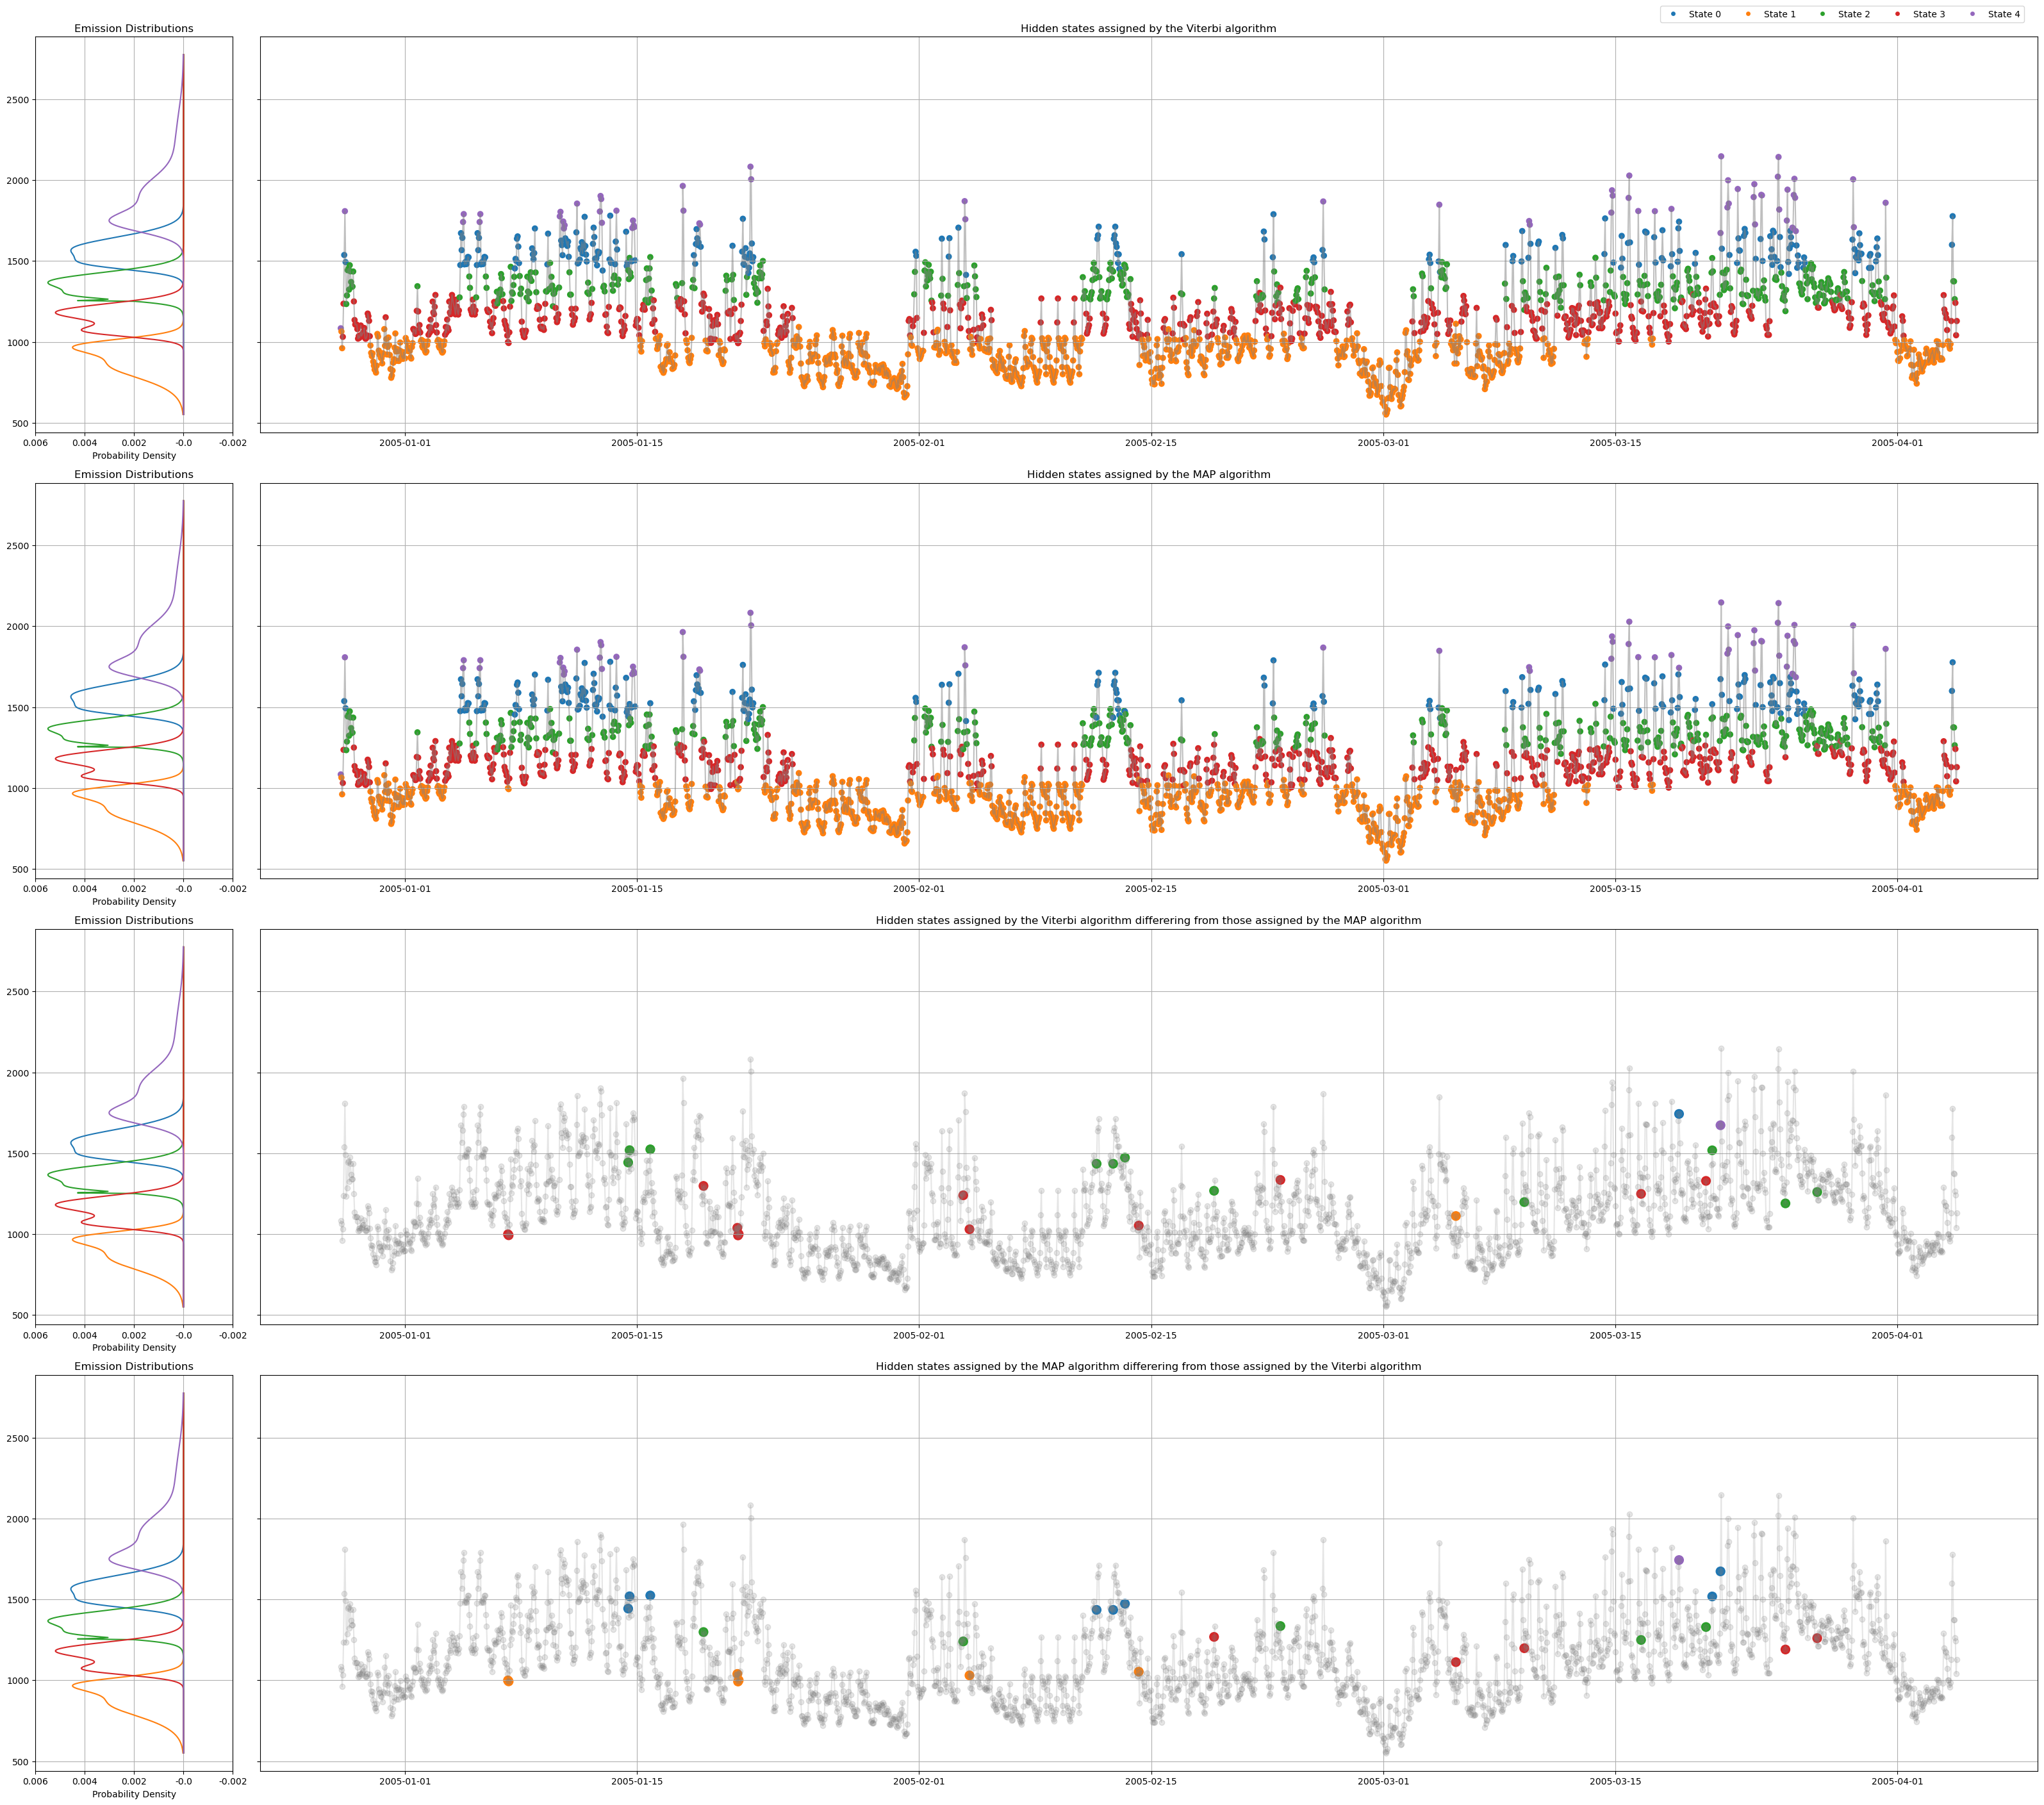

In [19]:
fig, axs = plt.subplots(
    4, 2, figsize=(32, 28), sharey=True, gridspec_kw={'width_ratios': (.1, .9)})

# plot emission distributions
for i in range(4):
    for j in range(best_model.n_components):
        mix_means = best_model.means_[j]
        mix_covars = best_model.covars_[j]
        mix_weights = best_model.weights_[j]
        g0 = stats.norm(mix_means[0], np.sqrt(mix_covars[0]))
        xs = np.linspace(np.min(data[SENSOR]), np.max(data[SENSOR]), 500)
        ys = g0.pdf(xs)*mix_weights[0]
        for mix in range(1, best_model.n_mix):
            g = stats.norm(mix_means[mix], np.sqrt(mix_covars[mix]))
            ys += g.pdf(xs)*mix_weights[mix]
        axs[i][0].plot(
            -ys, xs,
            label=f'Learned', color=sns.color_palette('tab10')[j])
        axs[i][0].set_xticks(
            axs[i][0].get_xticks(),
            labels=-axs[i][0].get_xticks())
        axs[i][0].set_title(f'Emission Distributions')
        axs[i][0].set_xlabel('Probability Density')
        axs[i][0].grid()

# plot hidden states assigned by the algorithms
for i, alg in zip([0, 1], ['Viterbi', 'MAP']):
    if alg == 'Viterbi': states = viterbi_final_states
    else: states = map_final_states
    axs[i][1].scatter(
        final_seq.index,
        final_seq, c=[sns.color_palette('tab10')[s] for s in states])
    axs[i][1].plot(final_seq, color='gray', alpha=0.5)
    axs[i][1].set_title(f'Hidden states assigned by the {alg} algorithm')
    handles, _ = axs[i][1].get_legend_handles_labels()
    axs[i][1].grid()

# plot observations assigned to different states by the algorithms
diff_idx = np.where(viterbi_final_states != map_final_states)[0]
for i, alg in zip([2, 3], ['Viterbi', 'MAP']):
    if alg == 'Viterbi': states = viterbi_final_states
    else: states = map_final_states
    axs[i][1].scatter(
        final_seq.index[diff_idx], final_seq.iloc[diff_idx],
        c=[sns.color_palette('tab10')[s] for s in states[diff_idx]], s=100)
    axs[i][1].plot(final_seq, color='gray', alpha=0.2, marker='o')
    axs[i][1].set_title(
        f'Hidden states assigned by the {alg} algorithm'
        f' differering from those assigned by the '
        f"{'MAP' if alg=='Viterbi' else 'Viterbi'} algorithm")
    axs[i][1].grid()

# add legend
legend_handles = []
for i in range(best_model.n_components):
    color = sns.color_palette('tab10').as_hex()[i]
    points_handle = plt.Line2D(
        [0], [0], marker='o', color='w',
        markerfacecolor=color, label=f'State {i}')
    legend_handles.append(points_handle)
legend_handles += handles
fig.legend(
    handles=legend_handles, loc='center', bbox_to_anchor=(0.9, 1),
    ncol=best_model.n_components);
fig.tight_layout()

Few observations are assigned to different states by the two methods.

Counting the number of disagreements:

In [20]:
print('Number of observations assigned to different states:', diff_idx.shape[0])

Number of observations assigned to different states: 26


Plotting the confusion matrix between the state assignments of the two methods:

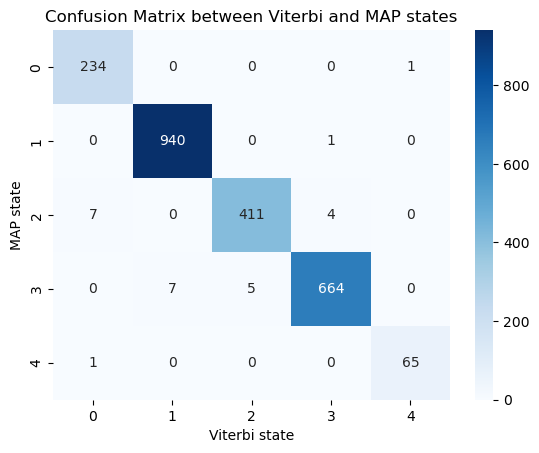

In [21]:
cm = pd.crosstab(
    viterbi_final_states, map_final_states,
    rownames=['viterbi_states'], colnames=['map_states'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix between Viterbi and MAP states');
plt.xlabel('Viterbi state');
plt.ylabel('MAP state');

Plotting the distribution of observations assigned to different states by the two methods:

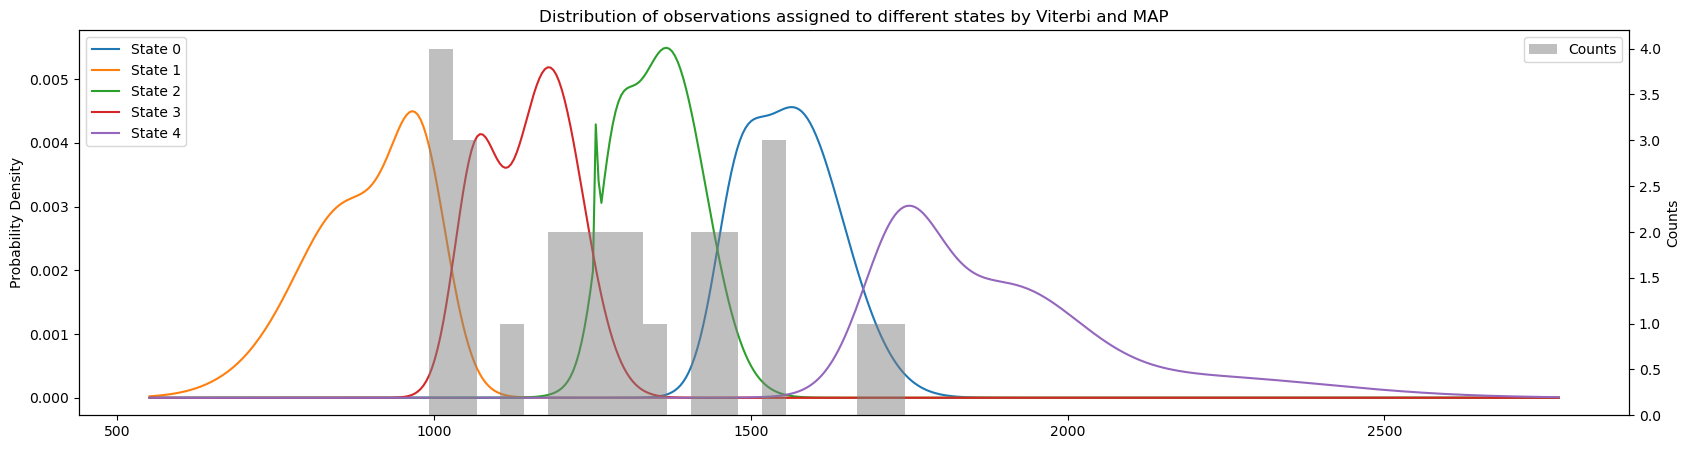

In [22]:
fig = plt.figure(figsize=(20, 5))
# plot emission distributions
for j in range(best_model.n_components):
    mix_means = best_model.means_[j]
    mix_covars = best_model.covars_[j]
    mix_weights = best_model.weights_[j]
    g0 = stats.norm(mix_means[0], np.sqrt(mix_covars[0]))
    xs = np.linspace(np.min(data[SENSOR]), np.max(data[SENSOR]), 500)
    ys = g0.pdf(xs)*mix_weights[0]
    for mix in range(1, best_model.n_mix):
        g = stats.norm(mix_means[mix], np.sqrt(mix_covars[mix]))
        ys += g.pdf(xs)*mix_weights[mix]
    plt.plot(
        xs, ys,
        label=f'State {j}', color=sns.color_palette('tab10')[j])
    plt.ylabel('Probability Density')
    plt.legend(loc='upper left')
# plot histogram of observations assigned to different states
ax2 = plt.twinx()
ax2.hist(
    final_seq.iloc[diff_idx].values, bins=20,
    alpha=0.5, color='gray', label='Counts');
ax2.set_ylabel('Counts')
plt.legend(loc='upper right')
plt.title(f'Distribution of observations assigned to different states by Viterbi and MAP');

The observations assigned to different states by the two methods mainly concentrate towards the boundaries of the regimes.

Plotting the distribution of observations assigned to different states by the two methods, grouped by date, month, hour and day of the week:

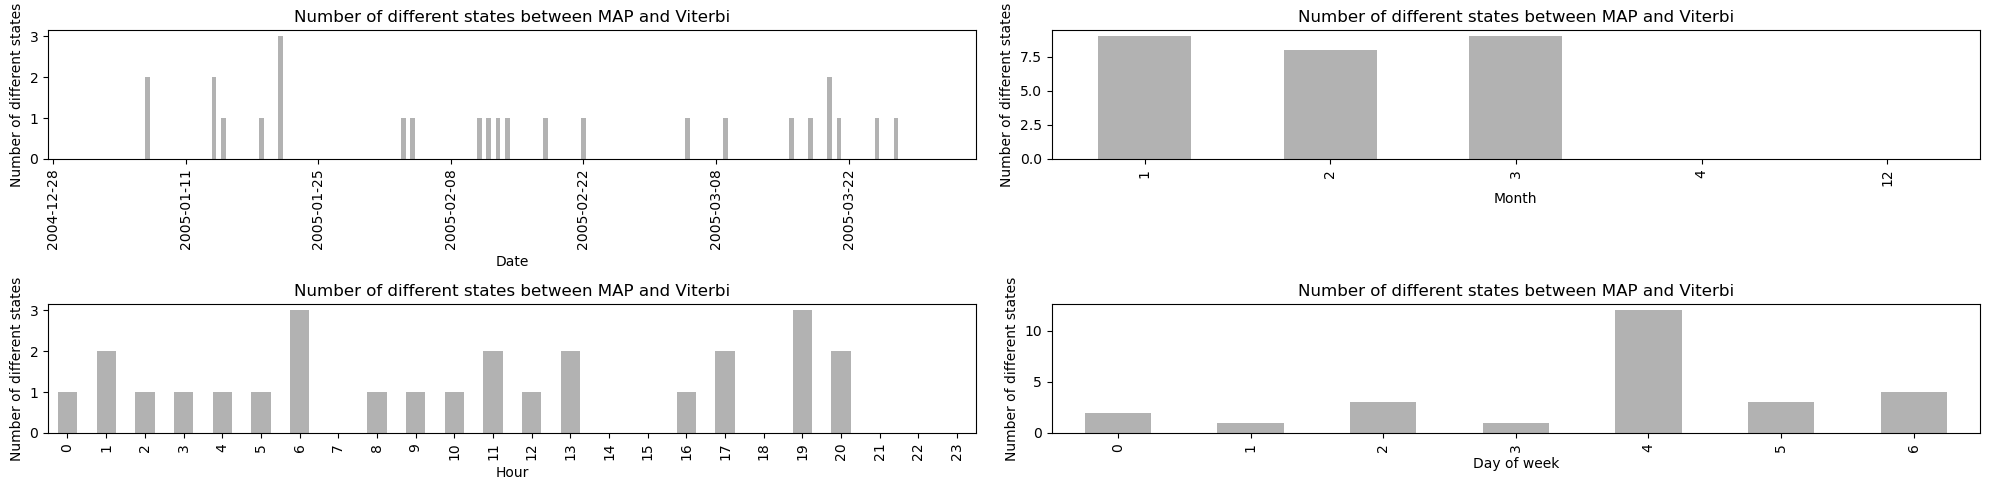

In [23]:
final_seq['MAP!=Viterbi'] = viterbi_final_states != map_final_states

fig, axs = plt.subplots(2, 2, figsize=(20, 16))

final_seq.groupby(final_seq.index.date).sum().plot(
    kind='bar',
    y='MAP!=Viterbi',
    ylabel='Number of different states',
    xlabel='Date',
    title='Number of different states between MAP and Viterbi',
    alpha=0.6, color='gray',
    ax=axs[0][0])
axs[0][0].legend().remove()
axs[0][0].set_xticks(axs[0][0].get_xticks()[::14])

final_seq.groupby(final_seq.index.month).sum().plot(
    kind='bar',
    y='MAP!=Viterbi',
    figsize=(20, 5),
    ylabel='Number of different states',
    xlabel='Month',
    title='Number of different states between MAP and Viterbi',
    alpha=0.6, color='gray',
    ax=axs[0][1])
axs[0][1].legend().remove()

final_seq.groupby(final_seq.index.hour).sum().plot(
    kind='bar',
    y='MAP!=Viterbi',
    figsize=(20, 5),
    ylabel='Number of different states',
    xlabel='Hour',
    title='Number of different states between MAP and Viterbi',
    alpha=0.6, color='gray',
    ax=axs[1][0])
axs[1][0].legend().remove()

final_seq.groupby(final_seq.index.dayofweek).sum().plot(
    kind='bar',
    y='MAP!=Viterbi',
    figsize=(20, 5),
    ylabel='Number of different states',
    xlabel='Day of week',
    title='Number of different states between MAP and Viterbi',
    alpha=0.6, color='gray',
    ax=axs[1][1])
axs[1][1].legend().remove()
fig.tight_layout()

final_seq.drop(columns='MAP!=Viterbi', inplace=True)

Interestingly, the discrepancies between the two methods are more frequent on fridays. However, being the number of disagreements relatively low, this result may not be statistically significant.

Plotting the distribution of MAP state assignment probabilities:

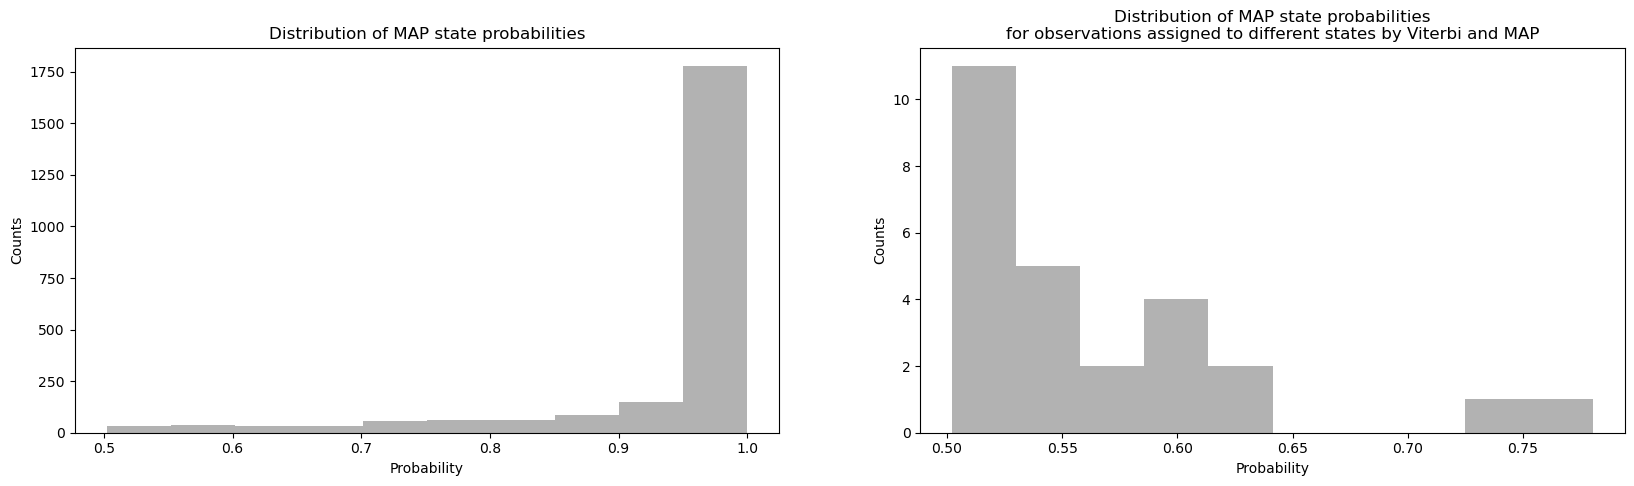

In [24]:
map_probas = best_model.predict_proba(final_seq)
max_map_idx = np.argmax(map_probas, axis=1)
max_map_probas = map_probas[np.arange(map_probas.shape[0]), max_map_idx]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].hist(max_map_probas, bins=10, alpha=0.6, color='gray');
axs[0].set_ylabel('Counts')
axs[0].set_xlabel('Probability');
axs[0].set_title('Distribution of MAP state probabilities');

axs[1].hist(max_map_probas[diff_idx], alpha=0.6, color='gray');
axs[1].set_ylabel('Counts')
axs[1].set_xlabel('Probability');
axs[1].set_title('Distribution of MAP state probabilities\n'
    'for observations assigned to different states by Viterbi and MAP');

Generally MAP assigns states with high probability, but the observations assigned to different states by Viterbi and MAP have lower probabilities.

Comparing transitions between MAP states with the actual transition matrix:

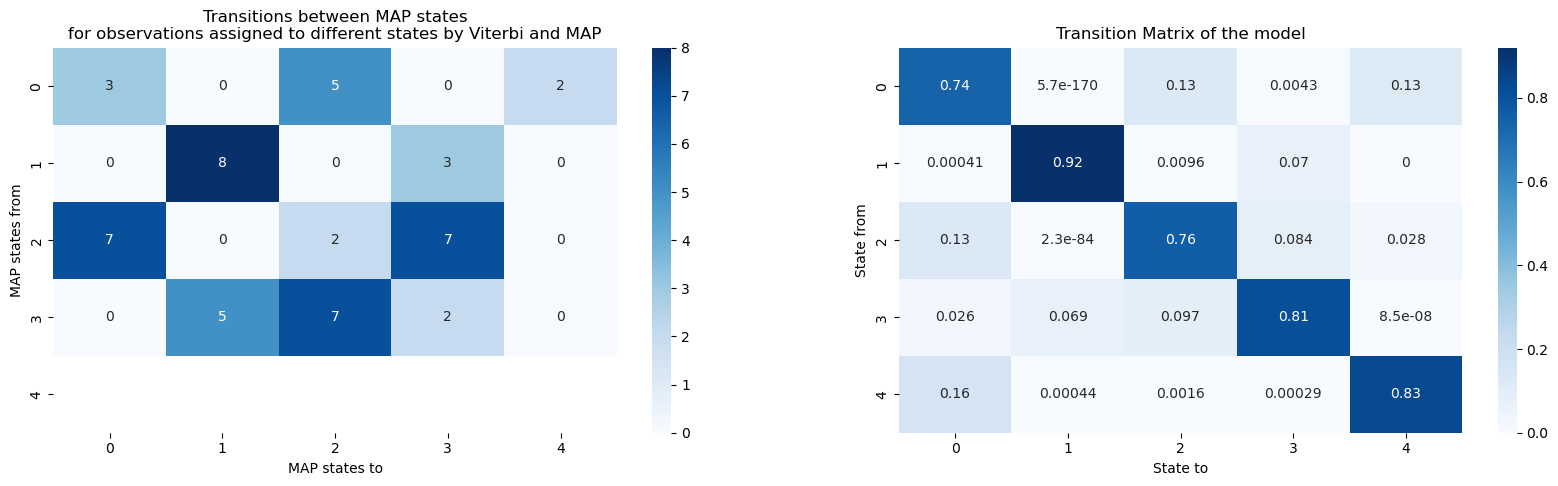

In [25]:
# transitions 'to' observations assigned to different states
tmat1 = pd.crosstab(
    map_final_states[diff_idx-1],
    map_final_states[diff_idx],
    rownames=['MAP states from'], colnames=['MAP states to'])
# transitions 'from' observations assigned to different states
tmat2 = pd.crosstab(
    map_final_states[diff_idx],
    map_final_states[diff_idx+1],
    rownames=['MAP states from'], colnames=['MAP states to'])
tmat = tmat1 + tmat2
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].set_title('Transitions between MAP states\n'
    'for observations assigned to different states by Viterbi and MAP')
sns.heatmap(tmat, cmap="Blues", annot=True, ax=axs[0])
sns.heatmap(best_model.transmat_, cmap="Blues", annot=True, ax=axs[1])
axs[1].set_title('Transition Matrix of the model')
axs[1].set_xlabel('State to')
axs[1].set_ylabel('State from');

MAP state transitions for observations assigned to different states by Viterbi and MAP are still plausible. The lowest transition probability is equal to 0.069 and involves 5 observations (out of 26).

### State assignment on whole timeseries

Instead of using the last 25% of the timeseries, I also used the whole timeseries to assign the states to the observations and check if the results are consistent with the previous analysis.

In [26]:
viterbi_states_full = best_model.decode(data, algorithm='viterbi')[1]
viterbi_states_full_f = viterbi_states_full[int(data.shape[0]*3/4):]
viterbi_diff_idx = np.where(viterbi_states_full_f != viterbi_final_states)[0]
pd.DataFrame({
    'index': viterbi_diff_idx,
    'Viterbi state when using the whole timeseries': viterbi_states_full_f[viterbi_diff_idx],
    'Viterbi state when using the last subsequence': viterbi_final_states[viterbi_diff_idx]
})

index  Viterbi state when using the whole timeseries  \
0      0                                              3   
1      1                                              3   

   Viterbi state when using the last subsequence  
0                                              4  
1                                              1

In [27]:
map_states_full_f = best_model.decode(data, algorithm='map')[1][int(data.shape[0]*3/4):]
map_diff_idx = np.where(map_states_full_f != map_final_states)[0]
pd.DataFrame({
    'index': map_diff_idx,
    'MAP state when using the whole timeseries': map_states_full_f[map_diff_idx],
    'MAP state when using the last subsequence': map_final_states[map_diff_idx]
})

index  MAP state when using the whole timeseries  \
0      0                                          3   
1      1                                          3   

   MAP state when using the last subsequence  
0                                          4  
1                                          1

With both algorithms, states assignments change consistently only for the first two observations.

### Viterbi vs MAP on data sampled from the model

Testing the ability of Viterbi and MAP to recover the true state from data sampled from the model:

In [28]:
sampled_em, sampled_st = best_model.sample(500, random_state=RANDOM_STATE)
viterbi_sampeld_st = best_model.decode(sampled_em, algorithm='viterbi')[1]
map_sampeld_st = best_model.decode(sampled_em, algorithm='map')[1]

pd.DataFrame({
    'Viterbi': {
        'Accuracy': np.sum(viterbi_sampeld_st == sampled_st) / sampled_st.size,
        'F1-score': f1_score(sampled_st, viterbi_sampeld_st, average='weighted')
    },
    'MAP': {
        'Accuracy': np.sum(map_sampeld_st == sampled_st) / sampled_st.size,
        'F1-score': f1_score(sampled_st, map_sampeld_st, average='weighted')
    }
})

Viterbi      MAP
Accuracy  0.976000  0.97400
F1-score  0.975944  0.97394

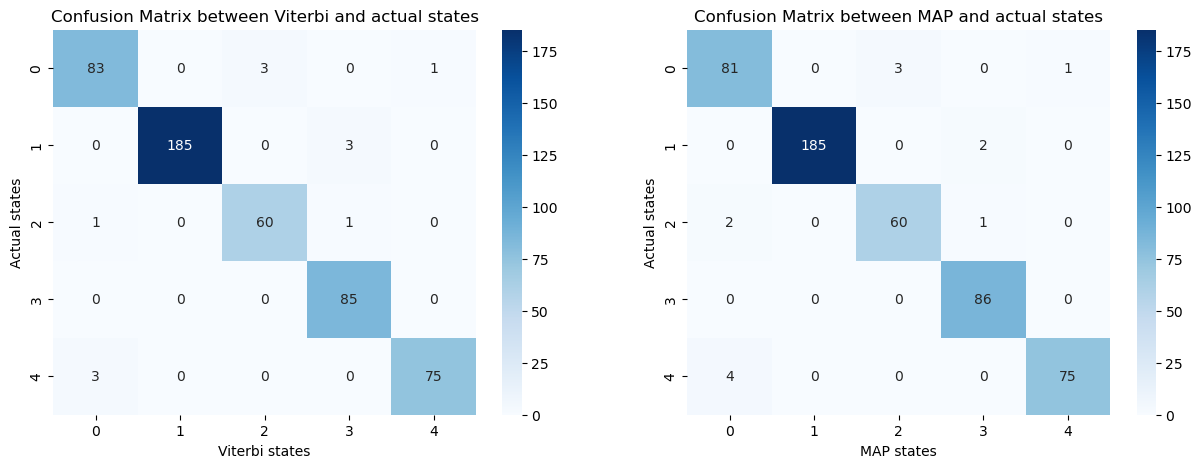

In [29]:
cmv = pd.crosstab(
    viterbi_sampeld_st, sampled_st,
    rownames=['viterbi_states'], colnames=['actual_states'])

cmm = pd.crosstab(
    map_sampeld_st, sampled_st,
    rownames=['MAP_states'], colnames=['actual_states'])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(cmv, annot=True, cmap='Blues', fmt='g', ax=axs[0])
axs[0].set_title('Confusion Matrix between Viterbi and actual states');
axs[0].set_xlabel('Viterbi states');
axs[0].set_ylabel('Actual states');

sns.heatmap(cmm, annot=True, cmap='Blues', fmt='g', ax=axs[1])
axs[1].set_title('Confusion Matrix between MAP and actual states');
axs[1].set_xlabel('MAP states');
axs[1].set_ylabel('Actual states');

Both the methods are able to recover the true states with high accuracy. The two methods err in similar ways.

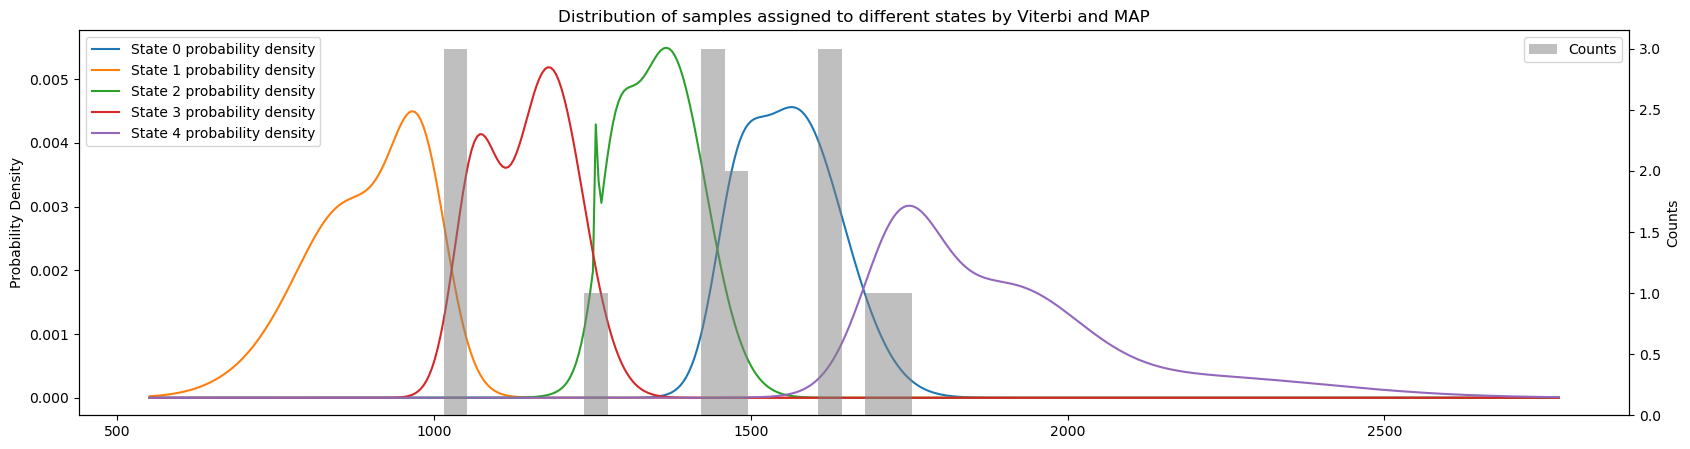

In [30]:
fig = plt.figure(figsize=(20, 5))
# plot emission distributions
diff_idx = np.where((viterbi_sampeld_st != sampled_st) | (map_sampeld_st != sampled_st))[0]
for j in range(best_model.n_components):
    mix_means = best_model.means_[j]
    mix_covars = best_model.covars_[j]
    mix_weights = best_model.weights_[j]
    g0 = stats.norm(mix_means[0], np.sqrt(mix_covars[0]))
    xs = np.linspace(np.min(data[SENSOR]), np.max(data[SENSOR]), 500)
    ys = g0.pdf(xs)*mix_weights[0]
    for mix in range(1, best_model.n_mix):
        g = stats.norm(mix_means[mix], np.sqrt(mix_covars[mix]))
        ys += g.pdf(xs)*mix_weights[mix]
    plt.plot(
        xs, ys,
        label=f'State {j} probability density', color=sns.color_palette('tab10')[j])
    plt.ylabel('Probability Density')
    plt.legend(loc='upper left')
# plot histogram of samples assigned to different states
ax2 = plt.twinx()
ax2.hist(sampled_em[diff_idx], bins=20, alpha=0.5, color='gray', label='Counts');
ax2.set_ylabel('Counts')
plt.legend(loc='upper right')
plt.title(f'Distribution of samples assigned to different states by Viterbi and MAP');

The observations assigned to different states by the two methods concentrate again towards the boundaries of the regimes.

## Interpreting the learned model

Plotting the transition matrix as a graph, hiding transitions with probability lower than 0.01:

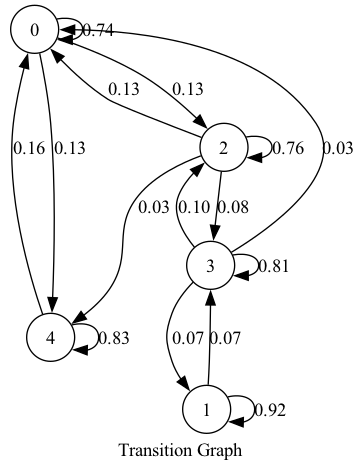

In [31]:
G = nx.MultiDiGraph()
for s in range(best_model.n_components):
    G.add_node(s, style='filled', fillcolor='white', shape='circle', fixedsize='true', width=0.5)
labels={}
edge_labels={}
for i, origin_state in enumerate(range(best_model.n_components)):
    for j, destination_state in enumerate(range(best_model.n_components)):
        rate = best_model.transmat_[i][j]
        if rate > 0.01:
            G.add_edge(origin_state, destination_state, weight=rate, label="{:.02f}".format(rate),len=2)
A = to_agraph(G)
A.layout('dot')
A.graph_attr.update(label='Transition Graph')
Image(A.draw(format='png'))

The node with the highest number of incoming transitions is state 0 (corresponding to medium-high regime), while the node with the lowest number of incoming transitions is state 1 (corresponding to low regime).

The nodes with the highest number of outgoing transitions are states 2 and 3 (corresponding to medium-low and medium regimes respectively).

As expected,  it is "easier" to transition from state of medium regimes to neighboring regimes.

Decoding the whole timeseries using the Viterbi algorithm:

In [32]:
data['state'] = viterbi_states_full

Plotting Viterbi state assignments grouped by hour of the day:

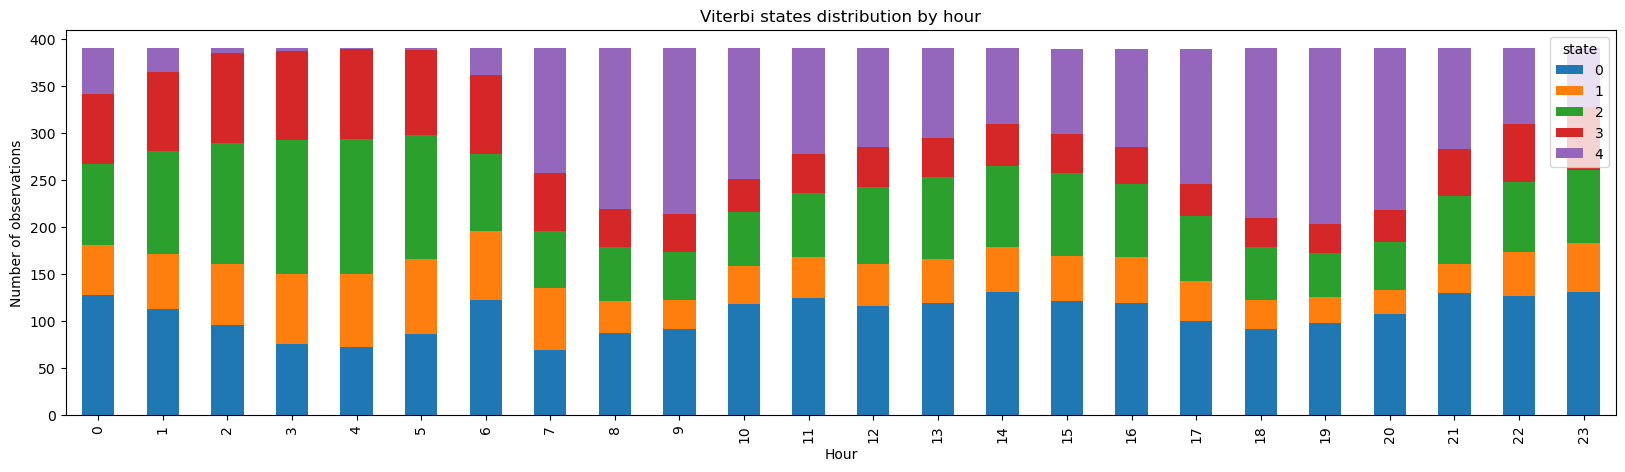

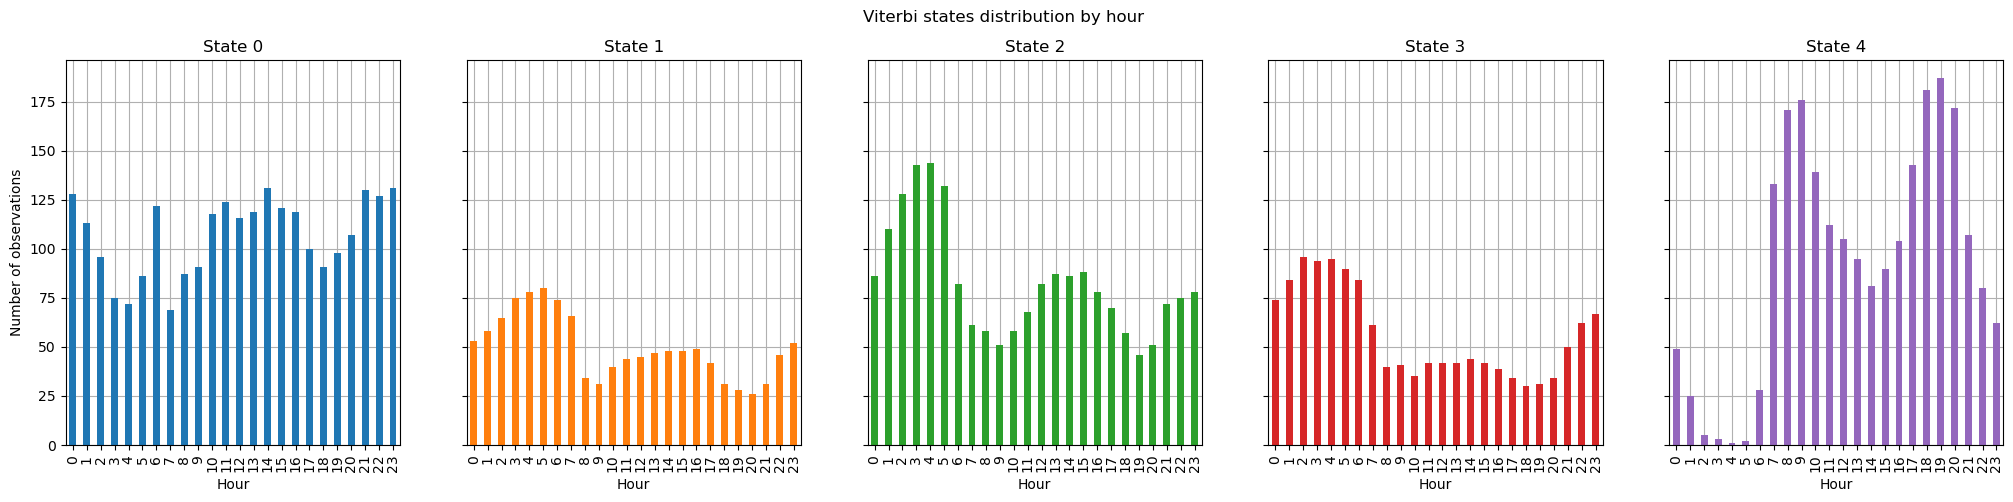

In [33]:
states_by_hour = data.groupby(data.index.hour)['state'].value_counts().unstack().fillna(0)

states_by_hour.plot(
    kind='bar', stacked=True, figsize=(20, 5),
    ylabel='Number of observations', xlabel='Hour',
    title='Viterbi states distribution by hour')

fig, axs = plt.subplots(1, data['state'].nunique(), figsize=(25, 5), sharey=True)
for i, state in enumerate(sorted(data['state'].unique())):
    states_by_hour.T.loc[state].plot(
        kind='bar', ax=axs[i],
        ylabel='Number of observations', xlabel='Hour',
        title=f'State {state}',
        color=sns.color_palette('tab10')[i])
    axs[i].set_axisbelow(True)
    axs[i].grid()
fig.suptitle('Viterbi states distribution by hour');

The distribution of observations assigned to states 1, 2 and 3 is similar, with peaks during the night and in the central hours of the day.

The distribution of observations assigned to state 4 (corresponding to high regime) is very low during the night and peaks at around 8-9 am and 6-7 pm (the hours with the highest traffic).

The distribution of observations assigned to state 0 (corresponding to medium-high regime) deviates from all the others.

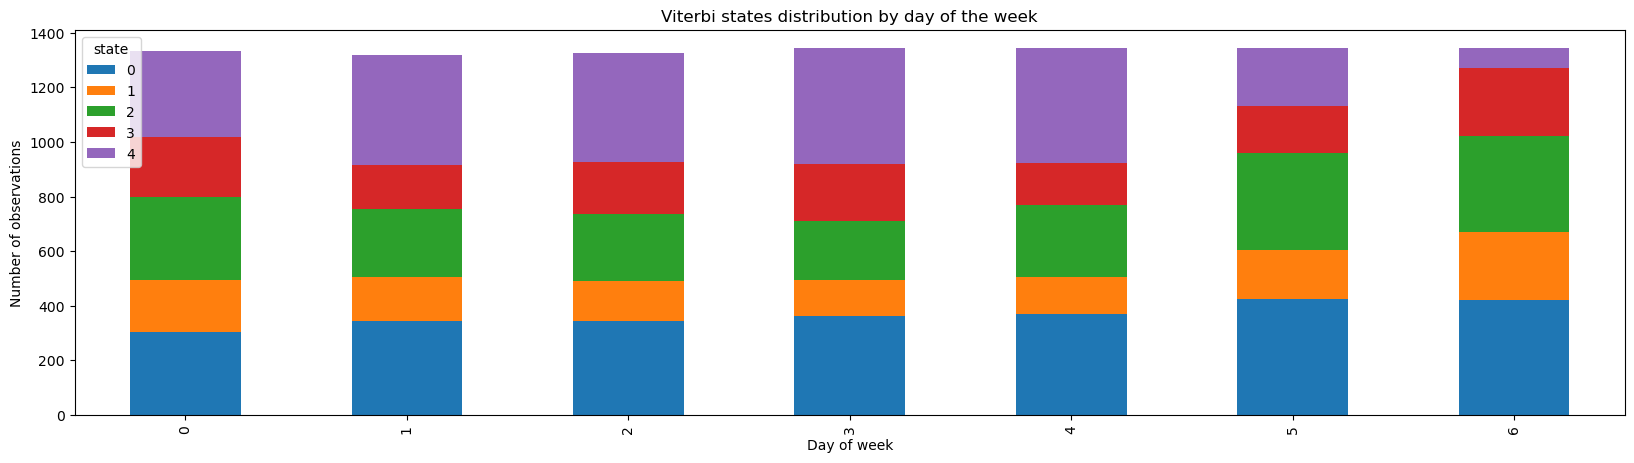

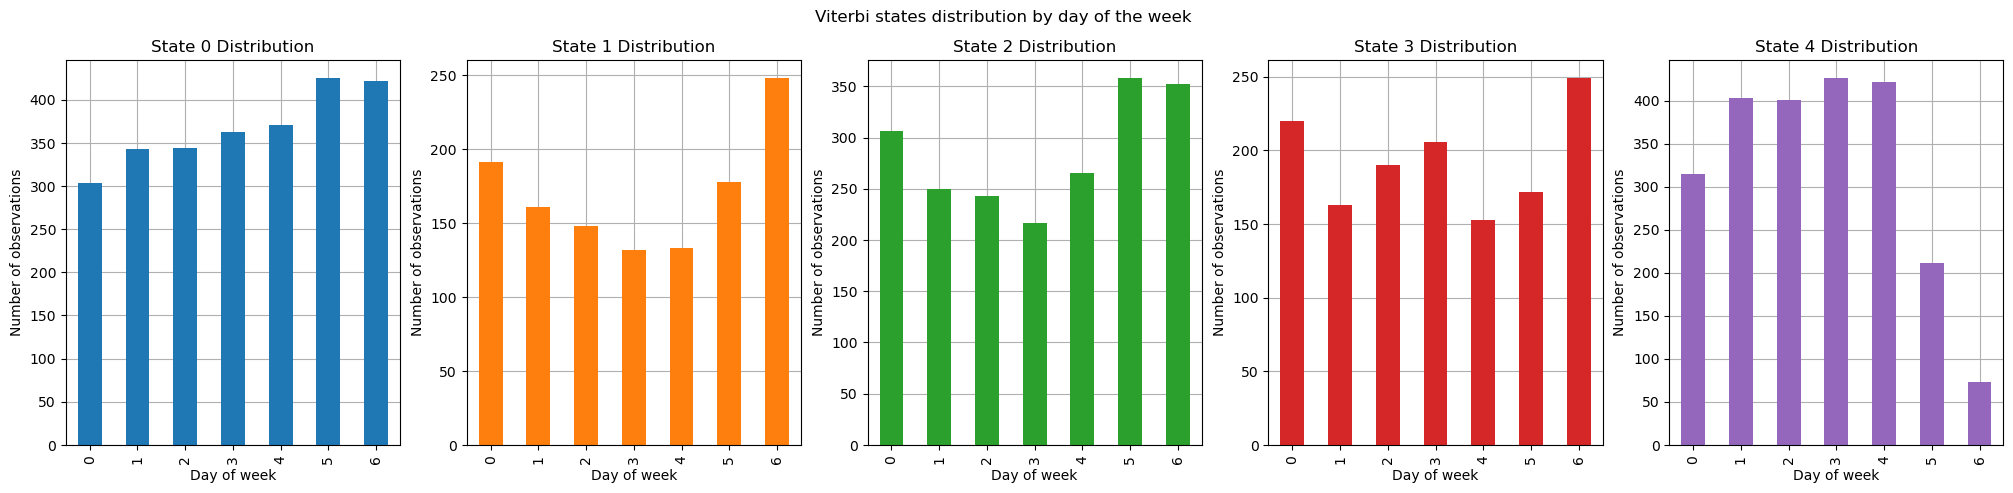

In [34]:
states_by_wday = data.groupby(data.index.dayofweek)['state'].value_counts().unstack().fillna(0)

states_by_wday.plot(
    kind='bar', stacked=True, figsize=(20, 5),
    ylabel='Number of observations', xlabel='Day of week',
    title='Viterbi states distribution by day of the week')

fig, axs = plt.subplots(1, data['state'].nunique(), figsize=(25, 5))
for i, state in enumerate(sorted(data['state'].unique())):
    states_by_wday.T.loc[state].plot(
        kind='bar', ax=axs[i],
        ylabel='Number of observations', xlabel='Day of week',
        title=f'State {state} Distribution',
        color=sns.color_palette('tab10')[i])
    axs[i].set_axisbelow(True)
    axs[i].grid()
fig.suptitle('Viterbi states distribution by day of the week');

The distribution of observations assigned to state 4 (corresponding to high regime) is lower during the weekend.

The distributions of observations assigned to states 1-2-3 are similar, 1 and 2 differ in the values on Saturdays, state 3 differs from state 1 in the central days of the week.

## Conclusion

A Hidden Markov Model with 5 states and Mixtures of 3 Gaussians for the emission distribution was the best choice for this dataset: sampling data from the model and comparing it with the original data showed that this model fits very well the training data. 

The hidden states of the model reflects 5 regimes of the data: low, medium-low, medium, medium-high and high levels of $NO_2$.

Viterbi and posterior decoding algorithms exhibit concordance in state assignments. Discrepancies tend to arise predominantly near regime boundaries.

### Weak aspects and ways to improve the analysis

Model selection was done testing the models on the last 25% of the data, which includes all the winter months. The different meteorological conditions could have influenced the results. However, given the sequential nature of the data, a more balanced split is not immediate to implement.

When dealing with continuous distributions, the optimization surface is complex and good initial estimates may be needed to avoid local maxima [1, 2]. This problem was addressed by training the models multiple times and selecting the best model according to the log-likelihood, but a more sophisticated initialization strategy could have been implemented.

# References
- [1] Lawrence R. Rabiner. A tutorial on hidden Markov models and selected applications in speech recognition. Proceedings of the IEEE 77.2 (1989), pages 257-286.
- [2] Lawrence R. Rabiner et al. Some properties of continuous hidden markov models representations. AT&T technical journal 64.6 (1985), pages 1251-1270.